# Hydromass example

Let's start by loading the packages...

In [1]:
import numpy as np

import pyproffit

import hydromass

import matplotlib.pyplot as plt


In [2]:
datv, p2 = pyproffit.Reload('mhyd/test_save_pyproffit.fits')

DATA structure found
Corresponding pixels coordinates:  428.00000000000836 416.0000000000049
PSF structure found


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


We start by loading the images in pyproffit using the pyproffit.Data class

1. Here imglink=_'epic-obj-im-700-1200.fits'_ is the link to the image file (count map) to be loaded.
2. The option _explink=_'epic-exp-im-700-1200.fits' allows the user to load an exposure map for vignetting correction. In case this option is left blank, a uniform exposure of 1s is assumed for the observation.   
3. The option _bkglink=_'epic-back-oot-sky-700-1200.fits' allows to load an external background map, which will be used when extracting surface brightness profiles.

The images are then loaded into the _Data_ structure

In [2]:
datv = pyproffit.Data(imglink='../../cluster_data/VLP/MACS0451/epic-obj-im-700-1200.fits',
                    explink='../../cluster_data/VLP/MACS0451/epic-exp-im-700-1200.fits',
                    bkglink='../../cluster_data/VLP/MACS0451/comb-back-tot-sky-700-1200.fits')

# To load instead a Voronoi image:
#datv=pyproffit.Data('../../cluster_data/VLP/MACS0451/voronoi_MACS0451.fits',voronoi=True)

# Filter out point sources by loading a DS9 region file
datv.region('../../cluster_data/VLP/MACS0451/src_voronoi.reg')



Excluded 41 sources


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


<h2> Profile extraction </h2>

Now we define a _Profile_ object and fit the background with a constant.

<p>The class <i>Profile</i> is designed to contain all the Proffit profile extraction features (not all of them have been implemented yet). The "method" argument specifies the choice of the center:
<blockquote>
    <p> center_choice='<i>centroid</i>': compute image centroid and ellipticity </p>
    <p> center_choice='<i>peak</i>': use brightness peak </p>
    <p> center_choice='<i>custom_fk5</i>': use custom center in FK5 coordinates, provided by the "center_ra" and "center_dec" arguments
    <p> center_choice='<i>custom_ima</i>': like <i>custom_fk5</i> but with input coordinates in image pixels
</blockquote>
</p>

The other arguments are the following:
<blockquote>
    <p> maxrad=<i>rad</i>: define the maximum radius of the profile (in arcmin) </p>
    <p> binsize=<i>size</i>: the width of the bins (in arcsec) </p>
    <p> center_ra=<i>ra</i>, center_dec=<i>dec</i>: position of the center (if method=3 or method=4) </p>
    <p> binning='<i>binning</i>': specify binnig scheme: <i>linear</i> (default), <i>log</i>, or <i>custom</i>. In the <i>custom</i> case, an array with the binning definition should be provided through the option bins=<i>array</i>
    <p> centroid_region=<i>radius</i>: for centroid calculation (center_choice=<i>centroid</i>), optionally provide a radius within which the centroid will be computed, instead of the entire image.
</blockquote>

<h3> Now let's extract the profile...</h3>


In [3]:

prof = pyproffit.Profile(datv, center_choice='peak', binsize=5, maxrad=15.)


prof.SBprofile()

mod = pyproffit.Model(pyproffit.Const)
fitter = pyproffit.Fitter(model=mod, profile=prof, bkg=-3.8, fitlow=7., fithigh=15.)
fitter.Migrad()


Determining X-ray peak
Coordinates of surface-brightness peak: 428.0 416.0
Corresponding FK5 coordinates:  73.5456401039549 -3.0148262711063816
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 122.6                      │              Nfcn = 30               │
│ EDM = 9.85e-11 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │

<Figure size 432x288 with 0 Axes>

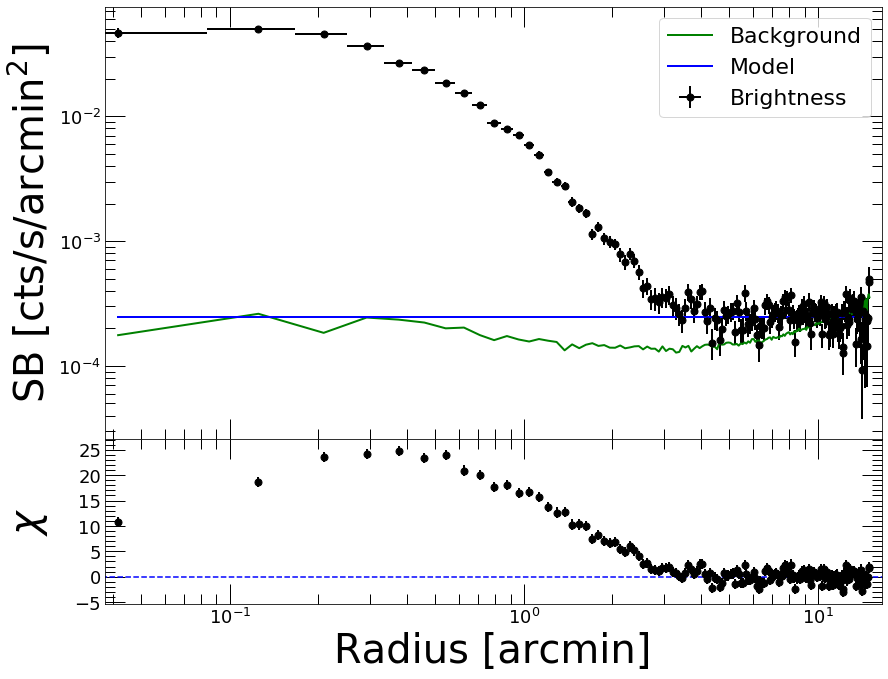

In [4]:

prof.Plot(model=mod)

Here we have fitted the background with a constant in the radial range 7-15 arcmin. 

Now let's extract a new profile with logarithmic binning and subtract the fitted background

Determining X-ray peak
Coordinates of surface-brightness peak: 428.0 416.0
Corresponding FK5 coordinates:  73.5456401039549 -3.0148262711063816


<Figure size 432x288 with 0 Axes>

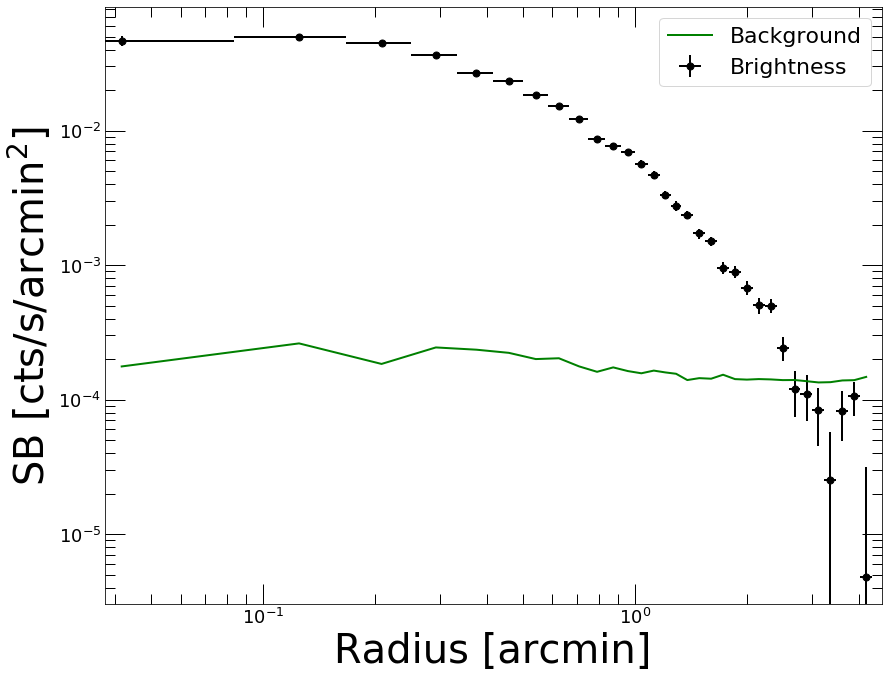

In [5]:
p2 = pyproffit.Profile(datv, center_choice='peak', binsize=5, maxrad=4.5, binning='log')
# p2.MedianSB()
p2.SBprofile()
p2.Backsub(fitter)

p2.Plot()

## Model the PSF

To model the PSF we can either supply a function or an image. The function should take an array of radii (in arcmin) and return the 1D PSF profile.


In [3]:
def fking(x):
    r0=0.0883981
    alpha=1.58918
    return np.power(1.+(x/r0)**2,-alpha)

# p2.PSF(psffunc=fking)


Now we need to define some parameters of our source

In [4]:
z_m0451 = 0.5398 # redshift
nh_m0451 = 0.0454 # NH
rsp = '/home/deckert/Documents/Work/cluster_data/scripts/m1.rsp' # on-axis response file

p2.Emissivity(z=z_m0451, nh=nh_m0451, kt=8.0, rmf=rsp, elow=0.7, ehigh=1.2)


20.97

In [5]:
p2.Save('mhyd/test_save_pyproffit.fits')

# Hydromass definition

We are now ready to load the hydromass.Mhyd class. 

The constructor of the Mhyd class requires the following input:
<blockquote>
    <p> profile=<i>prof</i>: a pyproffit.Profile object including the SB profile </p>
    <p> spec_data=<i>file</i>: a FITS file containing spectral data, using the usual X-COP format </p>
    <p> sz_data=<i>file</i>: a FITS file containing the Planck data in Etienne's format </p>
    <p> redshift=<i>z</i>: source redshift </p>
    <p> cosmo=<i>cosmo</i>: adopted cosmology in astropy.cosmology format. If cosmo=None (default), use Planck15.</p>
    <p> directory=<i>dir</i>: name of output file directory. If directory=None (default), a subdirectory with name 'mhyd' will be created. </p>
    <p> f_abund='<i>angr</i>': abundance table definition for calculation of electron to proton ratio and mean molecular weight. Default='angr', also available are 'aspl' and 'grsa'.</p>
</blockquote>

Note that either spec_data or sz_data or both can be specified. 

In [6]:
spec_data = hydromass.SpecData(redshift=z_m0451,
                               spec_data='../../cluster_data/VLP/MACS0451/spectral_results_MACS0451.fits')

spec_data.PSF(pixsize=2.5/60., psffunc=fking)

tmhyd = hydromass.Mhyd(sbprofile=p2, 
                       spec_data=spec_data,
                       redshift=z_m0451, 
                       cosmo=pyproffit.cosmo)


Reading spectral data from file ../../cluster_data/VLP/MACS0451/spectral_results_MACS0451.fits
No output directory name provided, will output to subdirectory "mhyd" 
Luminosity distance to the source: 3199.29 Mpc
At the redshift of the source 1 arcmin is 392.511 kpc


# Hydromass.Model class

Now let us define a mass model. This is done with the hydromass.Model class, which accepts the following option:

<blockquote>
    <p> massmod=<i>NFW</i>: mass model definition. Available models are NFW, EIN2, EIN3, BUR, ISO, and HER. </p>
    <p> delta=<i>val</i>: overdensity at which R_delta and c_delta are defined in the model (default=200). </p>
    <p> start=<i>start</i>: an array containing the mean values of the Gaussian priors on the parameters. If None, default values for each model will be set. </p>
    <p> sd=<i>sd</i>: an array contianing the sigma of the Gaussian priors on the parameters. If None, default values for each model will be set.</p>
    <p> limits=<i>limits</i>: a 2D-array containing upper and lower limits for the parameter values. If None, default values for each model will be set.</p>
    <p> fixed=<i>fix</i>: a boolean array describing if a parameter is fixed or fitted. For instance, for a model with 2 parameters for which we want to fix the first one, we pass fix=[True, False]. If fix=True, the value given in start is used. By default all parameters are fitted. </p>
</blockquote>

Now let's define an NFW model with default parameters

In [7]:

model = hydromass.Model(massmod='NFW')


In [8]:
#spec_data.psfmat

## Emissivity conversion

Now we need to compute the conversion factor between count rate and emissivity. This is done by running an XSPEC command under the hood, so XSPEC must be accessible:

In [9]:
tmhyd.emissivity(nh=nh_m0451, rmf=rsp, elow=0.7, ehigh=1.2)

print('Conversion between count rate and emission measure: ', tmhyd.ccf)

Mean cluster temperature: 8.161195  keV
Conversion between count rate and emission measure:  21.35


## Running the code

We are now ready to run the reconstruction. This is done using the Mhyd.run() function, which supports the following parameters:

<blockquote>
    <p> model=<i>model</i>: hydromass.Model object containing the definition of the mass model. </p>
    <p> nmcmc=<i>1000</i>: number of output samples from PyMC3/NUTS run (default=1000).</p>
    <p> tune=<i>500</i>: number of PyMC3/NUTS tuning steps (default=500). Increasing the <i>tune</i> value leads to better convergence but slower runs.</p>
    <p> nmore=<i>5</i>: fine grid definition for mass model calculation. The spec_data/sz_data grid will be split into 2*nmore bins inside which mass and pressure derivatives will be computed. Increasing nmore leads to greater precision in model pressure calculaton, but obviously slower runs. </p>
    <p> p0_prior=<i>p0_prior</i>: array containing the mean and standard deviation of the Gaussian prior on P0.</p>
    <p> dmonly=<i>False</i>: decide whether we want to fit the total mass or the DM mass only by subtracing the baryonic mass (default=False).</p>
    <p> mstar=<i>mstar</i>: in case dmonly=True, input a stellar mass profile as a 2D array including R (in kpc) and M_star (in Msun) in the two columns. </p>
    <p> fit_bkg=<i>False</i>: choose whether we want to fit the background on-the-fly and the counts using Poisson statistics, or if we use directly a background-subtracted brightness profile (default option), in which case Gaussian statistics is used. </p>
    <p> bkglim=<i>bkglim</i>: in case fit_bkg=True, set the maximum detection radius beyond which it is assumed that the source is negligible with respect to the background. If bkglim=None it will be assumed that the source is important everywhere.</p>
    <p> back=<i>back</i>: in case fit_bkg=True, give an input value for the background and set a narrow Gaussian prior centered on this value. If back=None the input value will be estimated as the mean value at r>bkglim.</p>
    <p> samplefile=<i>file</i>: name of output file to save the final PyMC3/NUTS samples.
</blockquote>


### Now let's do a quick test run...

In [10]:
# tmhyd.run(model=model, fit_bkg=True, bkglim=4.5)

tmhyd.run(model=model, nmcmc=100, tune=100)



Single conversion factor provided, we will assume it is constant throughout the radial range
Estimated value of P0: 0.000536316
coefs -187.90419872441586
cdelta_interval__ -1.7985669453191007
rdelta_interval__ -0.8404761994539018
logp0_interval__ -1.2303705795943691
Running HMC...


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 17400
Interrupted at 17,399 [8%]: Average Loss = 206.92
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logp0, rdelta, cdelta, coefs]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 41 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9608253300150552, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


Done.
 Total computing time is:  1.6706663290659587  minutes


/home/deckert/.local/lib/python3.8/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/deckert/.local/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [13]:
tmhyd.SaveModel(model=model)

In [25]:
len(tmhyd.samplogp0)

4000

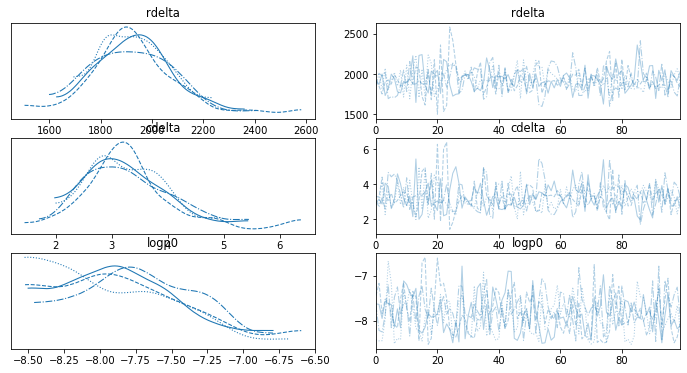

In [11]:
import arviz as az

#tmhyd.trace

nfw_loo = az.plot_trace(tmhyd.trace, var_names=['rdelta', 'cdelta', 'logp0'])

In [12]:
tmhyd.SaveModel(model, outfile='mhyd/test_save.fits')

### Let's plot the distribution of sample values at R500

<Figure size 432x288 with 0 Axes>

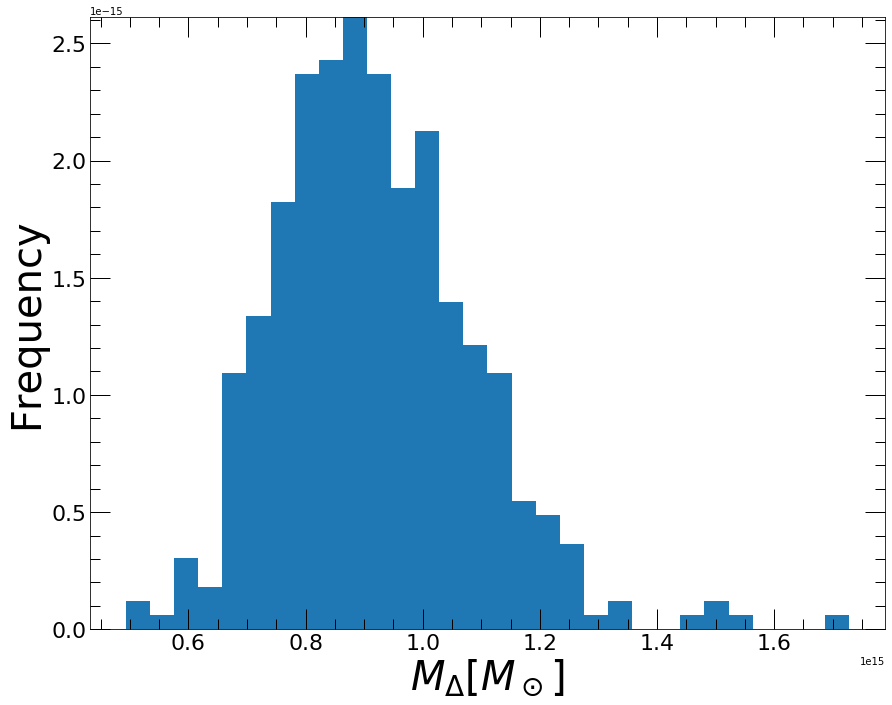

In [13]:
res_r500, fig = hydromass.calc_rdelta_mdelta(500, tmhyd, model, plot=True)

### ... And write the results at various overdensities to a file

In [14]:
hydromass.write_all_mdelta(tmhyd, model, rmin=100., rmax=4000.)

### Now let us inspect the results a little bit

pymc3 includes the "traceplot" function which allows to check the behavior of the output chains

<ipython-input-15-8806d58601d1>:3: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(tmhyd.trace, var_names=['cdelta','rdelta','logp0'])


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f74ab0928e0>,
      dtype=object)

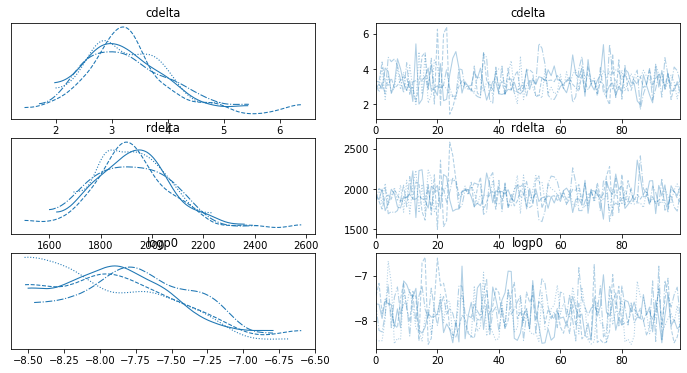

In [15]:
import pymc3 as pm

pm.traceplot(tmhyd.trace, var_names=['cdelta','rdelta','logp0'])

In [16]:
print(np.median(tmhyd.samppar[:,0]))
print(np.median(tmhyd.samppar[:,1]))

3.2153512361205276
1919.6494966016967


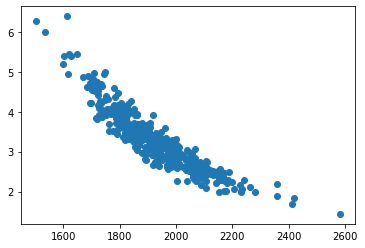

In [17]:
plt.plot(tmhyd.samppar[:,1], tmhyd.samppar[:,0], 'o')

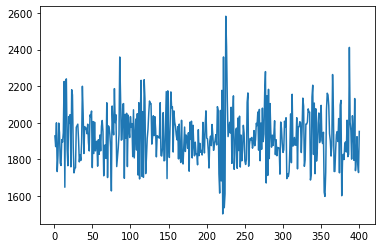

In [18]:
plt.plot(np.arange(1,len(tmhyd.samppar[:,1])+1,1), tmhyd.samppar[:,1])

Despite the small number of samples and tuning steps, the chain has converged. Now let's check the quality of the fit.

In [19]:
print(np.percentile(tmhyd.samppar[:,1], [50.-68.3/2., 50., 50.+68.3/2.]))

[1786.69801155 1919.6494966  2068.06103931]


/home/deckert/.local/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


<Figure size 432x288 with 0 Axes>

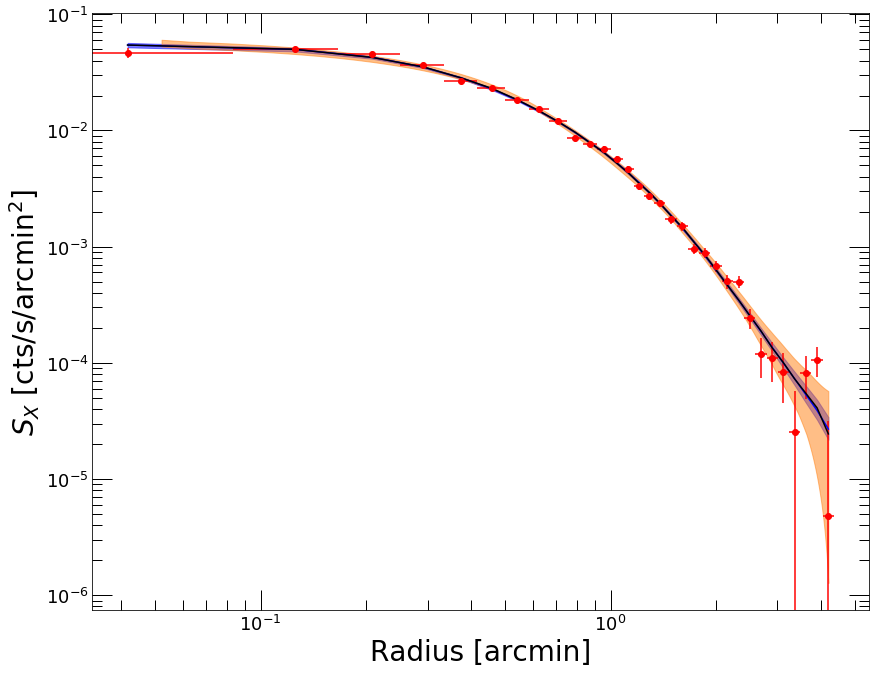

In [20]:
plt.clf()

fig = plt.figure(figsize=(13,10))
ax_size = [0.14, 0.14,
               0.83, 0.83]
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radius [arcmin]', fontsize=28)
plt.ylabel('$S_{X}$ [cts/s/arcmin$^2$]', fontsize=28)

plt.plot(p2.bins, tmhyd.sb, color='blue')
plt.fill_between(p2.bins, tmhyd.sb_lo, tmhyd.sb_hi, color='blue', alpha=0.5)
plt.errorbar(p2.bins, p2.profile, xerr=p2.ebins, yerr=p2.eprof, fmt='o', color='red')

plt.plot(p2.bins, np.median(tmhyd.ppc_sb['sb'], axis=0), color='black')
# plt.fill_between(p2.bins, np.percentile(tmhyd.ppc_sb['sb'], 50.-68.3/2., axis=0), 
#                  np.percentile(tmhyd.ppc_sb['sb'], 50.+68.3/2., axis=0),
#                  color='orange',alpha=0.5)

az.plot_hdi(
    p2.bins,
    tmhyd.ppc_sb['sb'],
    ax=ax,
    hdi_prob=.68,
)


# Looks good

## Now for the temperature profile...

<Figure size 432x288 with 0 Axes>

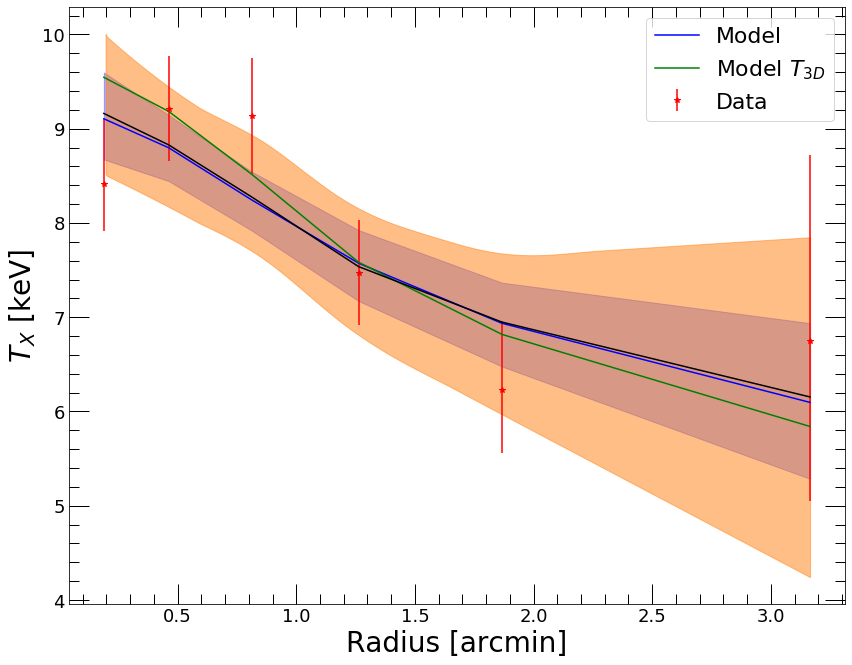

In [21]:
import arviz as az

plt.clf()

fig = plt.figure(figsize=(13,10))
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)

plt.xlabel('Radius [arcmin]', fontsize=28)
plt.ylabel('$T_{X}$ [keV]', fontsize=28)
plt.errorbar(tmhyd.spec_data.rref_x_am,tmhyd.spec_data.temp_x,yerr=np.array([tmhyd.spec_data.templ,tmhyd.spec_data.temph]),fmt='*',color='red', label='Data')
plt.plot(tmhyd.spec_data.rref_x_am,tmhyd.ktmod,color='blue', label='Model')
plt.fill_between(tmhyd.spec_data.rref_x_am, tmhyd.ktmod_lo, tmhyd.ktmod_hi, color='blue', alpha=0.3)
plt.plot(tmhyd.spec_data.rref_x_am,tmhyd.kt3d,color='green', label='Model $T_{3D}$')

plt.plot(tmhyd.spec_data.rref_x_am, np.median(tmhyd.ppc_kt['kt'], axis=0), color='black')
#plt.fill_between(tmhyd.spec_data.rref_x_am, np.percentile(tmhyd.ppc_kt['kt'], 50.-68.3/2., axis=0), 
#                 np.percentile(tmhyd.ppc_kt['kt'], 50.+68.3/2., axis=0),
#                 color='orange',alpha=0.5)

az.plot_hdi(
    tmhyd.spec_data.rref_x_am,
    tmhyd.ppc_kt['kt'],
    ax=ax,
    hdi_prob=.68
)

#plt.plot(tmhyd.spec_data.rref_x_am, tmhyd.ppc_kt['kt'].T, 'o', alpha=0.3)

plt.legend(fontsize=22)

(array([  1.,   4.,   7.,  16.,  30.,  57.,  74., 113.,  78.,  20.]),
 array([203.72011256, 204.90645537, 206.09279818, 207.279141  ,
        208.46548381, 209.65182662, 210.83816944, 212.02451225,
        213.21085506, 214.39719788, 215.58354069]),
 <a list of 10 Patch objects>)

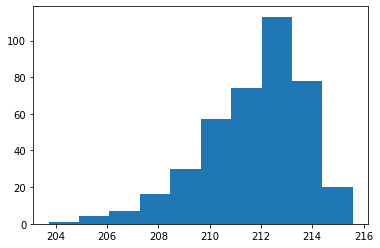

In [22]:
plt.hist(tmhyd.totlike)

In [23]:
az.loo(tmhyd.trace, var_name="sb")

/home/deckert/.local/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 400 by 32 log-likelihood matrix

         Estimate       SE
elpd_loo   215.12     9.78
p_loo        6.81        -

There has been a warning during the calculation. Please check the results.

### Let's inspect the mass profile

In [24]:
res_profile = hydromass.prof_hires(tmhyd, model)

res_mass = hydromass.mass_from_samples(tmhyd, model, rin=30.)


<Figure size 432x288 with 0 Axes>

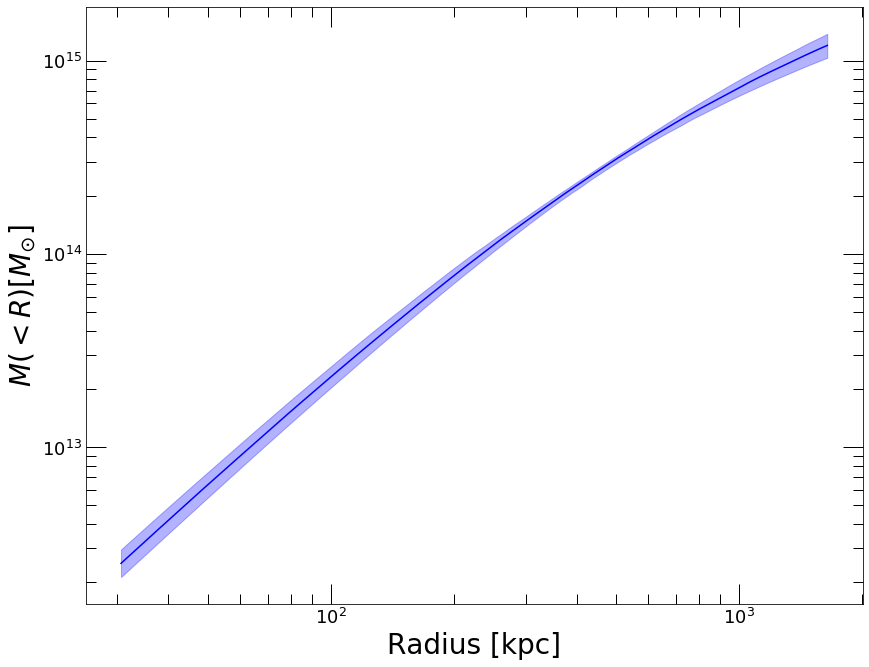

In [25]:
plt.clf()

fig = plt.figure(figsize=(13,10))
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)

plt.xlabel('Radius [kpc]', fontsize=28)
plt.ylabel('$M(<R) [M_{\odot}]$', fontsize=28)
plt.yscale('log')
plt.xscale('log')
plt.plot(res_mass['R_OUT'], res_mass['MASS'],color='blue')
plt.fill_between(res_mass['R_OUT'], res_mass['MASS_LO'], res_mass['MASS_HI'], color='blue', alpha=0.3)


In [26]:
from astropy.io import fits

fold = fits.open('../../cluster_data/VLP/MACS0451/MACS0451_hydro_mass.fits')
dold = fold[1].data
rold = dold['RADIUS']
mold = dold['M_NFW']
mold_lo = dold['M_NFW_LO']
mold_hi = dold['M_NFW_HI']

fold.close()

<Figure size 432x288 with 0 Axes>

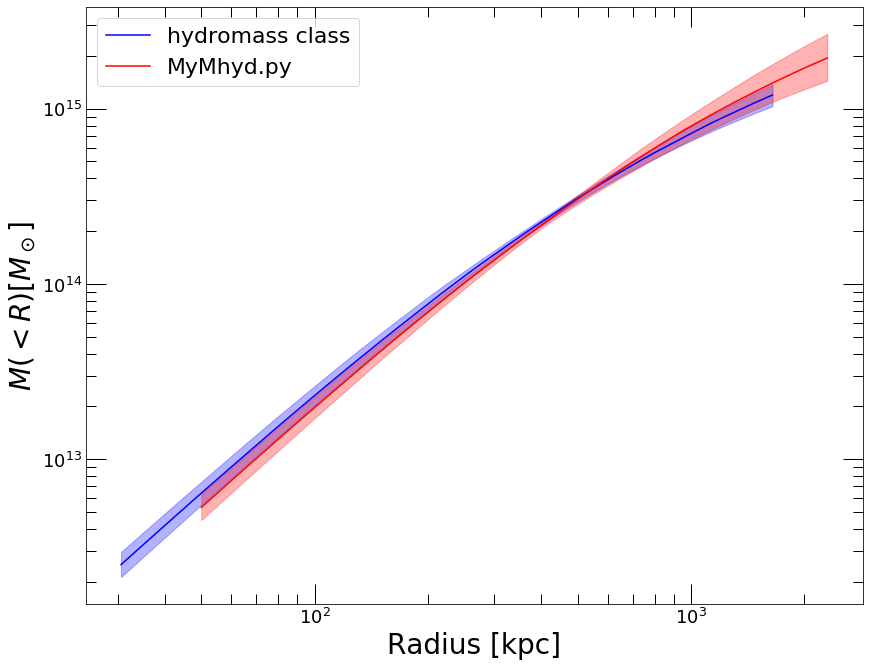

In [27]:
plt.clf()

fig = plt.figure(figsize=(13,10))
ax_size = [0.14, 0.14,
               0.83, 0.83]
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radius [kpc]', fontsize=28)
plt.ylabel('$M(<R) [M_\odot]$', fontsize=28)
plt.plot(res_mass['R_OUT'], res_mass['MASS'],color='blue', label='hydromass class')
plt.fill_between(res_mass['R_OUT'], res_mass['MASS_LO'], res_mass['MASS_HI'], color='blue', alpha=0.3)

plt.plot(rold, mold, color='red', label='MyMhyd.py')
plt.fill_between(rold, mold_lo, mold_hi, color='red', alpha=0.3)
plt.legend(fontsize=22)
#plt.savefig('tests/MACS0451_code_comparison.pdf')
# Hurray!

In [28]:
ccfprof = np.empty(p2.nbin)
kt3d = np.interp(p2.bins*tmhyd.amin2kpc, spec_data.rref_x, tmhyd.kt3d)

for i in range(p2.nbin):
    ccfprof[i] = hydromass.calc_emissivity(cosmo=pyproffit.cosmo, z=z_m0451, nh=nh_m0451, kt=kt3d[i], 
                                                elow=0.7, ehigh=1.2, rmf=rsp)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [29]:
tmhyd.ccf = ccfprof

tmhyd.run(model=model, nmcmc=100, tune=100)

Interpolating conversion factor profile onto the radial grid
Estimated value of P0: 0.000536612
coefs -187.90419872441586
cdelta_interval__ -1.7985669453191007
rdelta_interval__ -0.8404761994539018
logp0_interval__ -1.2303705795943691
Running HMC...


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 17800
Interrupted at 17,799 [8%]: Average Loss = 198.06
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logp0, rdelta, cdelta, coefs]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 61 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


Done.
 Total computing time is:  1.9192180633544922  minutes


/home/deckert/.local/lib/python3.8/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


<ipython-input-30-79d252a4e1db>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(tmhyd.trace, var_names=['cdelta','rdelta','logp0'])


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f74a5aec280>,
      dtype=object)

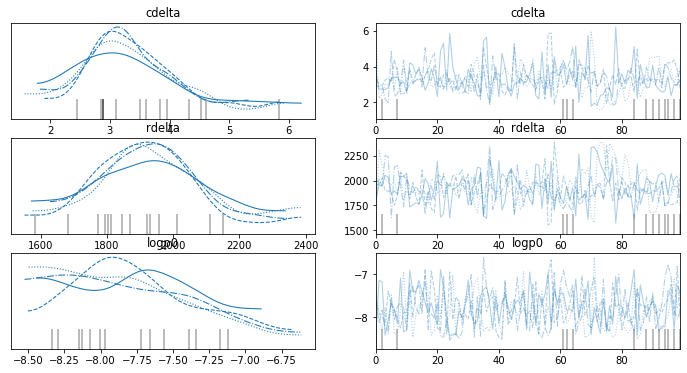

In [30]:
pm.traceplot(tmhyd.trace, var_names=['cdelta','rdelta','logp0'])

## Now let's redo the same thing with the Einasto model

In [6]:
modein3 = hydromass.Model(massmod='EIN3')

In [7]:
mhydein3 = hydromass.Mhyd(sbprofile=p2, 
                          spec_data=spec_data, 
                          redshift=z_m0451, 
                          cosmo=pyproffit.cosmo)

No output directory name provided, will output to subdirectory "mhyd" 
Luminosity distance to the source: 3199.29 Mpc
At the redshift of the source 1 arcmin is 392.511 kpc


In [8]:
mhydein3.emissivity(nh=nh_m0451, rmf=rsp, elow=0.7, ehigh=1.2)

Mean cluster temperature: 8.161195  keV


In [9]:
mhydein3.run(model=modein3, nmcmc=100, tune=100)

Single conversion factor provided, we will assume it is constant throughout the radial range
Estimated value of P0: 0.00053947
coefs -187.90419872441586
cdelta_interval__ -1.0691401415566637
rdelta_interval__ -0.8947154191299338
mu_interval__ -2.0443188713378415
logp0_interval__ -1.2303705795943691
Running HMC...


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 24700
Interrupted at 24,699 [12%]: Average Loss = 2,342.8
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logp0, mu, rdelta, cdelta, coefs]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 34 seconds.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.


Done.
 Total computing time is:  1.104120711485545  minutes


/home/deckert/.local/lib/python3.8/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/deckert/.local/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<ipython-input-10-785fb791d03e>:3: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(mhydein3.trace, var_names=['cdelta','rdelta','mu','logp0'])


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1a8f65c5b0>,
      dtype=object)

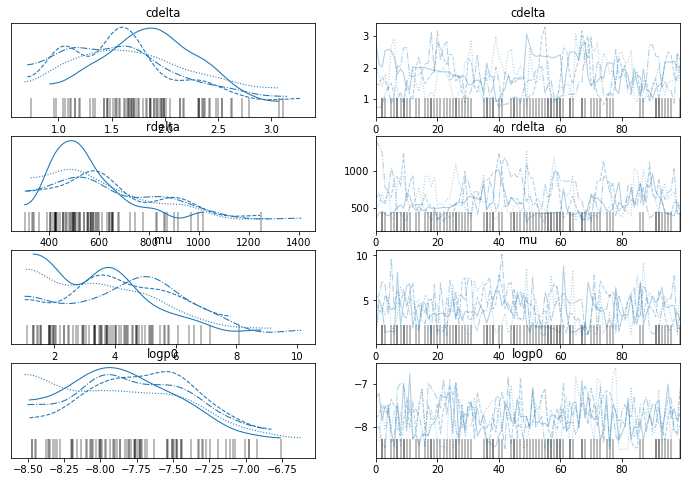

In [10]:
import pymc3 as pm

pm.traceplot(mhydein3.trace, var_names=['cdelta','rdelta','mu','logp0'])

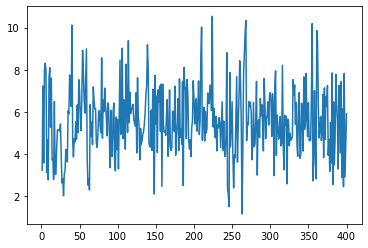

In [12]:
plt.plot(np.arange(1,len(mhydein3.samppar[:,2])+1,1), mhydein3.samppar[:,2])

<Figure size 432x288 with 0 Axes>

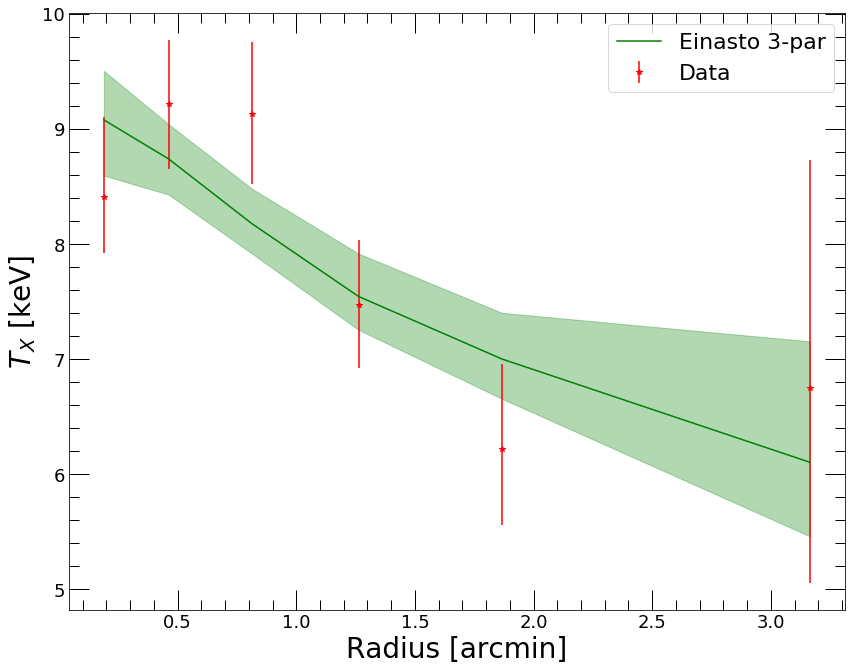

In [15]:
plt.clf()

ax_size = [0.14, 0.14,
               0.83, 0.83]

fig = plt.figure(figsize=(13,10))
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)

plt.xlabel('Radius [arcmin]', fontsize=28)
plt.ylabel('$T_{X}$ [keV]', fontsize=28)
plt.errorbar(mhydein3.spec_data.rref_x_am,mhydein3.spec_data.temp_x,yerr=np.array([mhydein3.spec_data.templ,mhydein3.spec_data.temph]),fmt='*',color='red', label='Data')
plt.plot(mhydein3.spec_data.rref_x_am,mhydein3.ktmod,color='green', label='Einasto 3-par')
plt.fill_between(mhydein3.spec_data.rref_x_am, mhydein3.ktmod_lo, mhydein3.ktmod_hi, color='green', alpha=0.3)
#plt.plot(tmhyd.spec_data.rref_x_am,tmhyd.ktmod,color='blue', label='NFW')
#plt.fill_between(tmhyd.spec_data.rref_x_am, tmhyd.ktmod_lo, tmhyd.ktmod_hi, color='blue', alpha=0.3)

plt.legend(fontsize=22)


In [16]:
res_ein = hydromass.mass_from_samples(mhydein3, modein3, rin=30.)


<Figure size 432x288 with 0 Axes>

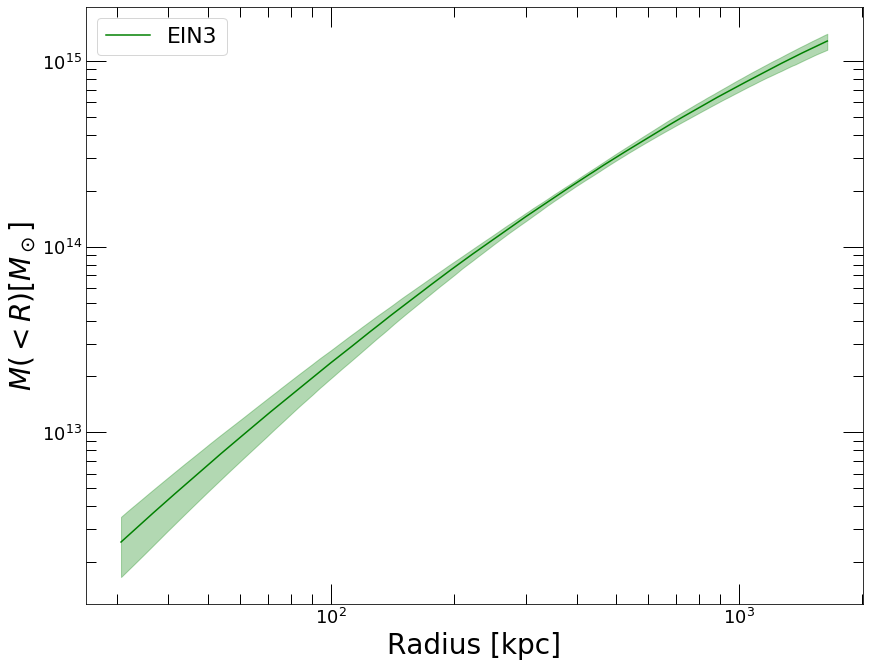

In [18]:
plt.clf()

fig = plt.figure(figsize=(13,10))
ax_size = [0.14, 0.14,
               0.83, 0.83]
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radius [kpc]', fontsize=28)
plt.ylabel('$M(<R) [M_\odot]$', fontsize=28)
#plt.plot(res_mass['R_OUT'], res_mass['MASS'],color='blue', label='NFW')
#plt.fill_between(res_mass['R_OUT'], res_mass['MASS_LO'], res_mass['MASS_HI'], color='blue', alpha=0.3)

#plt.plot(rold, mold, color='red', label='MyMhyd.py')
#plt.fill_between(rold, mold_lo, mold_hi, color='red', alpha=0.3)

plt.plot(res_ein['R_OUT'], res_ein['MASS'],color='green', label='EIN3')
plt.fill_between(res_ein['R_OUT'], res_ein['MASS_LO'], res_ein['MASS_HI'], color='green', alpha=0.3)

plt.legend(fontsize=22)
#plt.savefig('tests/MACS0451_code_comparison.pdf')
# Hurray!

In [19]:
log_lik = mhydein3.trace.log_likelihood

log_lik['tot'] = log_lik['sb'] + log_lik['kt']

In [21]:
import arviz as az

loo_ein3 = az.loo(mhydein3.trace, var_name='tot')

print(loo_ein3)

Computed from 400 by 192 log-likelihood matrix

         Estimate       SE
elpd_loo  1007.18    25.16
p_loo      113.79        -

There has been a warning during the calculation. Please check the results.


/home/deckert/.local/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [23]:
mhydein3.loo

Computed from 400 by 6 log-likelihood matrix

         Estimate       SE
elpd_loo    -8.97     1.29
p_loo        2.41        -

There has been a warning during the calculation. Please check the results.

In [24]:
mhydein3.waic

Computed from 400 by 6 log-likelihood matrix

          Estimate       SE
elpd_waic    -8.78     1.25
p_waic        2.22        -

There has been a warning during the calculation. Please check the results.

In [68]:
tmhyd.trace.log_likelihood['tot'] = tmhyd.trace.log_likelihood['sb'] + tmhyd.trace.log_likelihood['kt']

az.waic(tmhyd.trace, var_name='tot')

/home/deckert/.local/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 400 by 192 log-likelihood matrix

          Estimate       SE
elpd_waic  1007.47    25.07
p_waic      115.99        -

There has been a warning during the calculation. Please check the results.

TypeError: compare() got an unexpected keyword argument 'var_name'

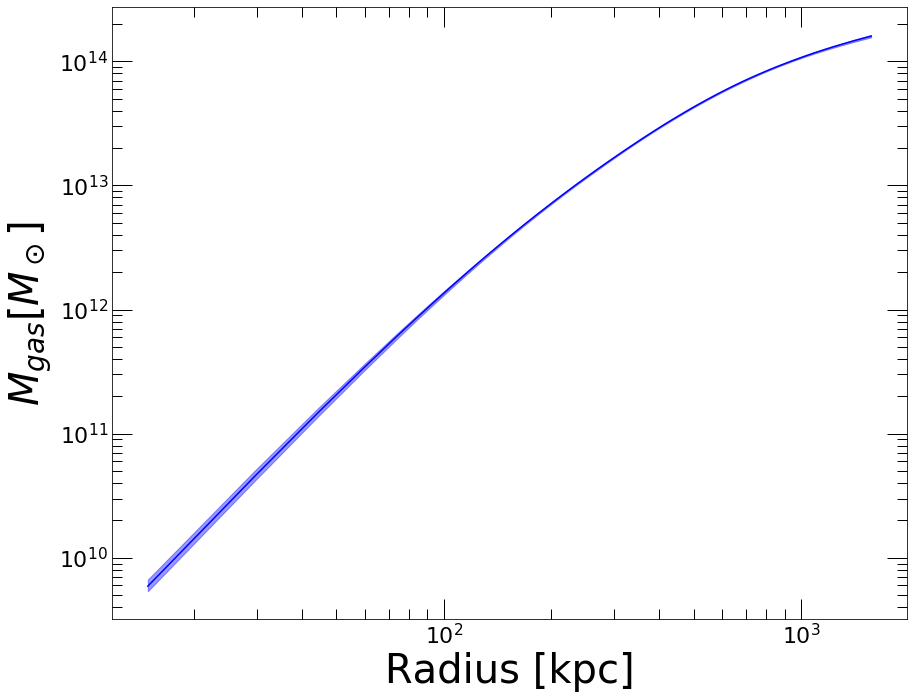

In [44]:
mgein, mgein_lo, mgein_hi, fig = hydromass.PlotMgas(mhydein3, plot=True)

(array([ 1.,  1.,  1.,  5.,  7., 10., 12.,  6., 21., 21., 22., 38., 29.,
        33., 26., 28., 27., 25., 16., 18., 16., 12.,  6.,  4.,  3.,  3.,
         2.,  2.,  3.,  2.]),
 array([ 1.16702951,  1.47925787,  1.79148623,  2.10371458,  2.41594294,
         2.72817129,  3.04039965,  3.352628  ,  3.66485636,  3.97708471,
         4.28931307,  4.60154143,  4.91376978,  5.22599814,  5.53822649,
         5.85045485,  6.1626832 ,  6.47491156,  6.78713991,  7.09936827,
         7.41159663,  7.72382498,  8.03605334,  8.34828169,  8.66051005,
         8.9727384 ,  9.28496676,  9.59719511,  9.90942347, 10.22165183,
        10.53388018]),
 <a list of 30 Patch objects>)

<Figure size 432x288 with 0 Axes>

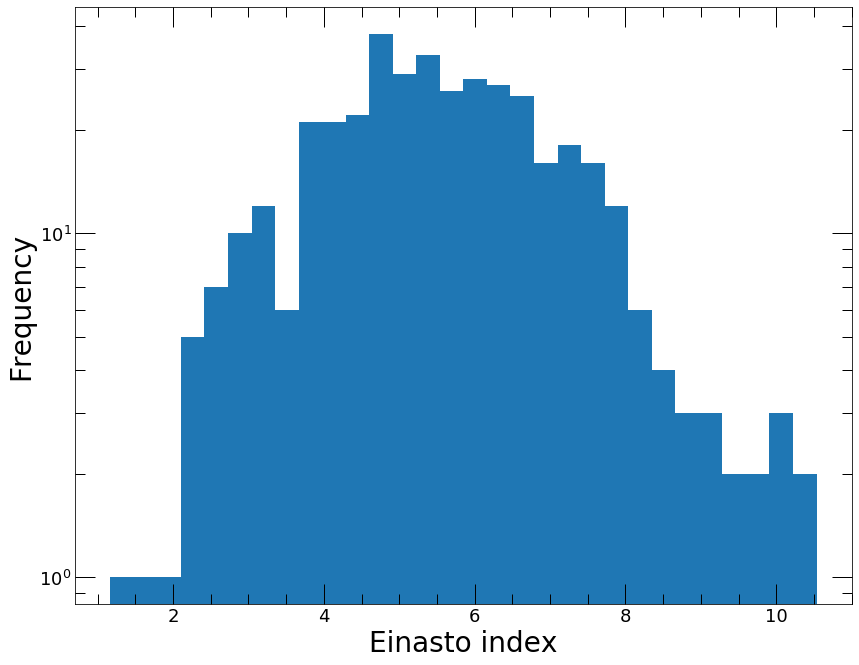

In [25]:
plt.clf()
fig=plt.figure(figsize=(13, 10))
ax = fig.add_axes(ax_size)
ax.minorticks_on()

ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Einasto index', fontsize=28)
plt.ylabel('Frequency', fontsize=28)
plt.hist(mhydein3.samppar[:,2], bins=30)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffa999589d0>,
      dtype=object)

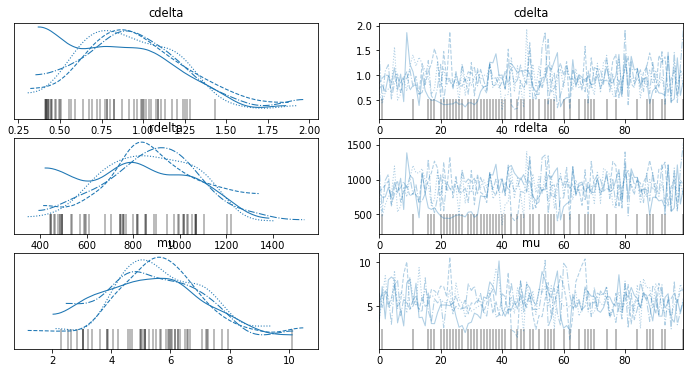

In [27]:
pm.plot_trace(mhydein3.trace, var_names=['cdelta', 'rdelta', 'mu'])

In [48]:
hydromass.write_all_mdelta(mhydein3, modein3, rmin=100., rmax=4000.)

# DM-only mass fit

Here we subtract the gas mass when performing the fit such that the best-fit model describes the contribution of dark matter only. No stellar mass is provided, but it can be easily added as an external constraint.

In [35]:
mnfwdm = hydromass.Mhyd(sbprofile=p2, 
                        spec_data=spec_data, 
                        redshift=z_m0451, 
                        cosmo=pyproffit.cosmo)

modnfwdm = hydromass.Model(massmod='NFW')

mnfwdm.emissivity(nh=nh_m0451, rmf=rsp, elow=0.7, ehigh=1.2)

No output directory name provided, will output to subdirectory "mhyd" 
Luminosity distance to the source: 3199.29 Mpc
At the redshift of the source 1 arcmin is 392.511 kpc
Mean cluster temperature: 8.161195  keV


In [36]:
mnfwdm.run(model=modnfwdm, nmcmc=100, tune=100, dmonly=True)

coefs -187.90419872441586
cdelta_interval__ -1.7985669453191007
rdelta_interval__ -0.8404761994539018
logp0_interval__ -1.2303705795943691
Running MCMC...


logp = 18.133, ||grad|| = 0.0080677: 100%|██████████| 774/774 [00:00<00:00, 1586.31it/s] 
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logp0, rdelta, cdelta, coefs]
Sampling 4 chains, 199 divergences: 100%|██████████| 800/800 [00:19<00:00, 42.03draws/s]
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5337875495449262, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5845686380758659, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_tre

Done.
 Total computing time is:  0.43874891599019367  minutes


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7d196405b0>,
      dtype=object)

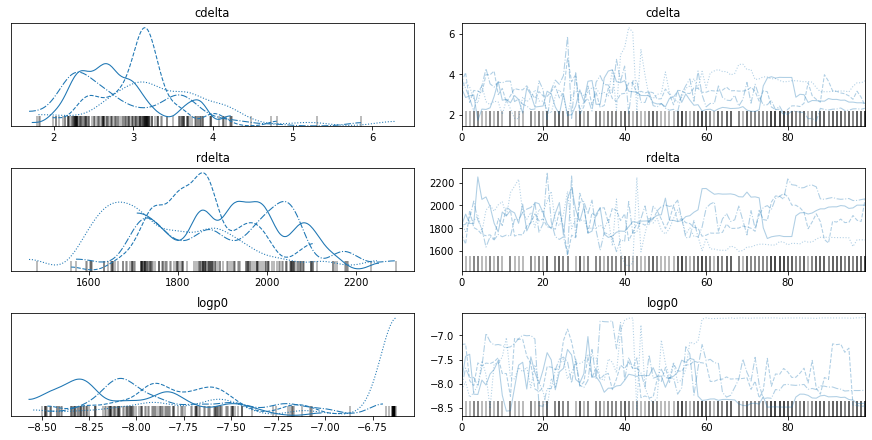

In [38]:
import pymc3 as pm

pm.traceplot(mnfwdm.trace, var_names=['cdelta', 'rdelta', 'logp0'])

In [39]:
res_mdm, fig = hydromass.mass_from_samples(Mhyd=mnfwdm, model=modnfwdm, plot=True)


ValueError: 
$M_{m gas}$
^
Expected end of text, found '$'  (at char 0), (line:1, col:1)

<Figure size 936x720 with 1 Axes>

<Figure size 432x288 with 0 Axes>

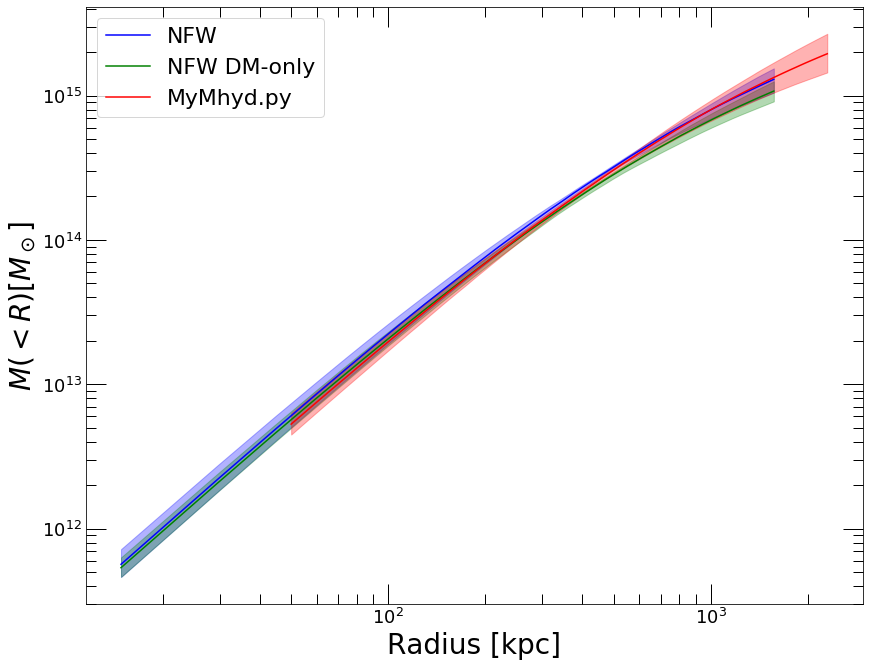

In [43]:
plt.clf()

fig = plt.figure(figsize=(13,10))
ax_size = [0.14, 0.14,
               0.83, 0.83]
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radius [kpc]', fontsize=28)
plt.ylabel('$M(<R) [M_\odot]$', fontsize=28)
plt.plot(res_mass['R_OUT'], res_mass['MASS'],color='blue', label='NFW')
plt.fill_between(res_mass['R_OUT'], res_mass['MASS_LO'], res_mass['MASS_HI'], color='blue', alpha=0.3)

plt.plot(res_mdm['R_OUT'], res_mdm['MASS'],color='green', label='NFW DM-only')
plt.fill_between(res_mdm['R_OUT'], res_mdm['MASS_LO'], res_mdm['MASS_HI'], color='green', alpha=0.3)

plt.plot(rold, mold, color='red', label='MyMhyd.py')
plt.fill_between(rold, mold_lo, mold_hi, color='red', alpha=0.3)
plt.legend(fontsize=22)


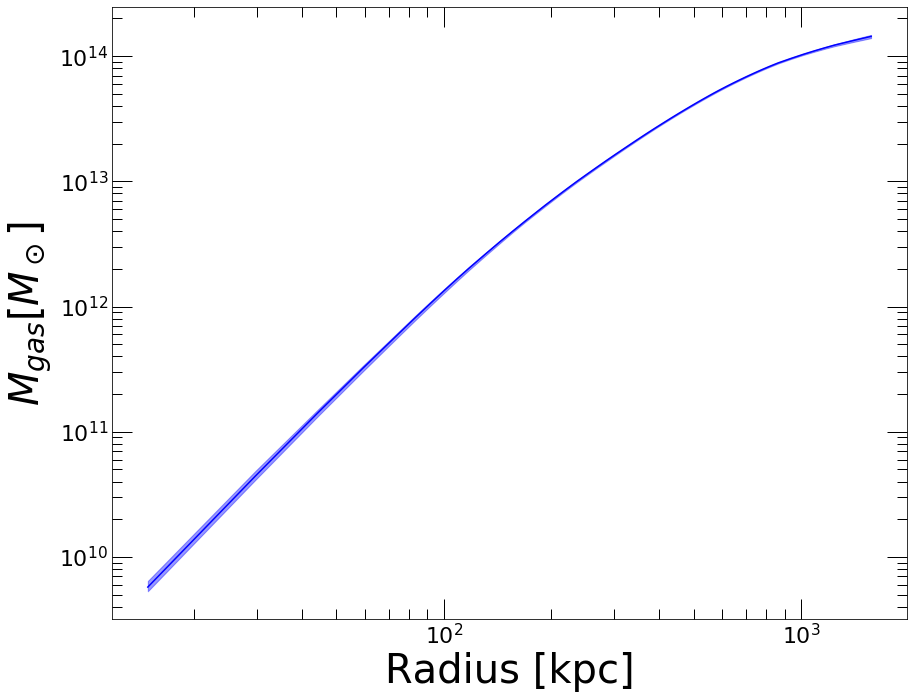

In [44]:
mg, mgl, mgh, fig = hydromass.PlotMgas(mnfwdm, plot=True)

In [45]:
profs_mdm = hydromass.prof_hires(mnfwdm, modnfwdm)

## Let's compare the DM-only + Mgas fit to the standard Mtot fit

<Figure size 432x288 with 0 Axes>

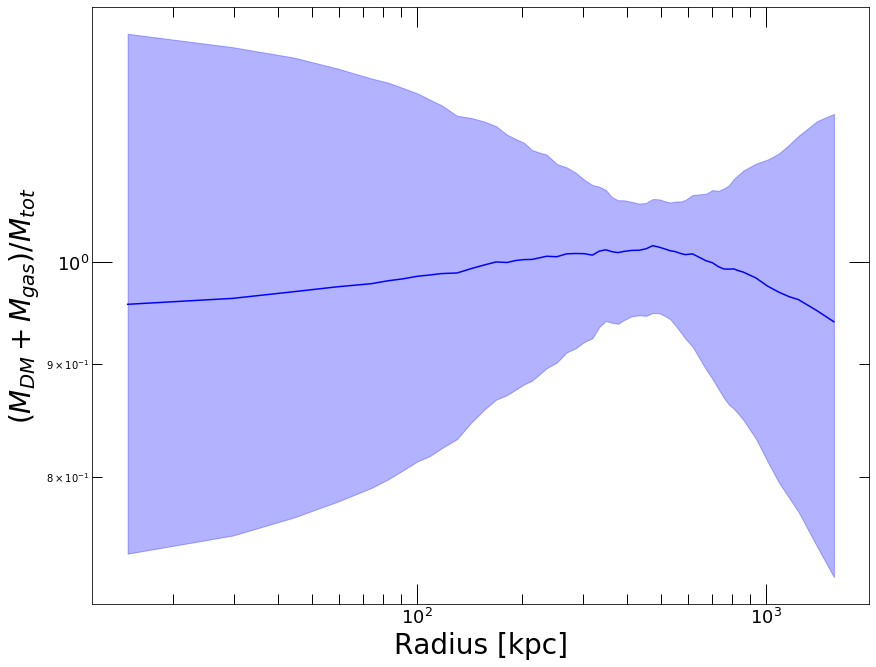

In [46]:
plt.clf()

fig = plt.figure(figsize=(13,10))
ax_size = [0.14, 0.14,
               0.83, 0.83]
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radius [kpc]', fontsize=28)
plt.ylabel('$(M_{DM} + M_{gas}) / M_{tot}$', fontsize=28)


tm, tmlo, tmhi = res_mass['MASS'], res_mass['MASS_LO'], res_mass['MASS_HI']

tmdm, tmdmlo, tmdmhi = res_mdm['MASS'], res_mdm['MASS_LO'], res_mdm['MASS_HI']

ratio = (tmdm + mg) / tm

erat_lo = np.sqrt( ((tmdm - tmdmlo) / tm) ** 2 +  ((tmdm + mg) / tm **2 * (tm - tmlo)) ** 2 )

erat_hi = np.sqrt( ((tmdmhi - tmdm) / tm) ** 2 +  ((tmdm + mg) / tm **2 * (tmhi - tm)) ** 2 )

plt.plot(res_mass['R_OUT'], ratio,color='blue')
plt.fill_between(res_mass['R_OUT'], ratio - erat_lo, ratio + erat_hi, color='blue', alpha=0.3)


## Overdensity profiles for DM and gas

<Figure size 432x288 with 0 Axes>

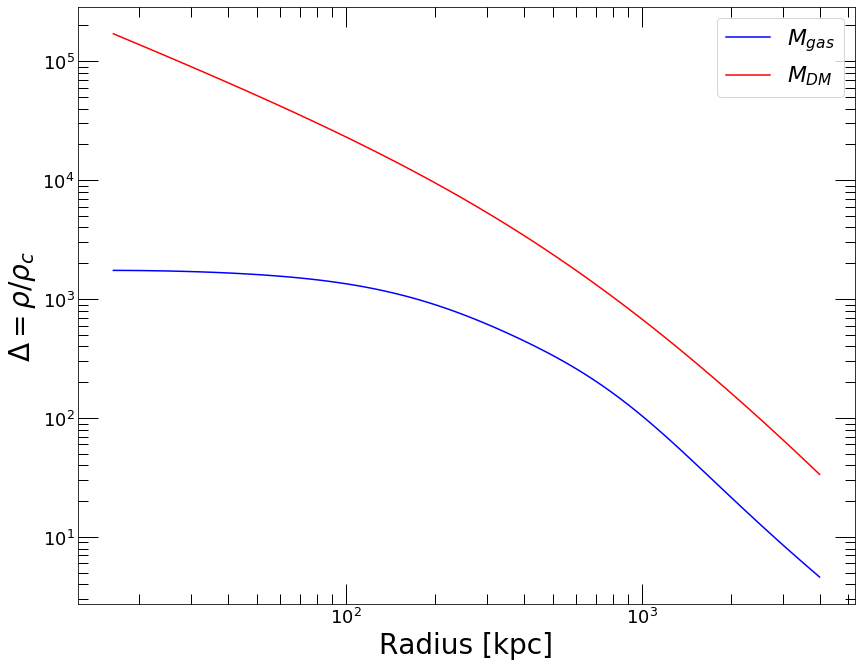

In [47]:
rbt, mbar_ov = hydromass.mbar_overdens(4000., mnfwdm.samples[0], mnfwdm)

plt.clf()
fig = plt.figure(figsize=(13,10))
ax_size = [0.14, 0.14,
               0.83, 0.83]
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radius [kpc]', fontsize=28)
plt.ylabel('$\Delta = \\rho/\\rho_{c}$', fontsize=28)
plt.plot(rbt, mbar_ov, color='blue', label='$M_{gas}$')

mtot_ov = hydromass.delta_func(rbt, mnfwdm, modnfwdm, np.array([mnfwdm.samppar[0]]))
plt.plot(rbt, mtot_ov[0], color='red', label='$M_{DM}$')

plt.legend(fontsize=22)


## Finally write the results for the DM-only run...

In [48]:
hydromass.write_all_mdelta(Mhyd=mnfwdm, model=modnfwdm, outfile=mnfwdm.dir+'/NFW_DMonly.jou')

## Forward modeling

In [51]:
mforw = hydromass.Mhyd(sbprofile=p2, 
                        spec_data=spec_data, 
                        redshift=z_m0451, 
                        cosmo=pyproffit.cosmo)

modforw = hydromass.Forward(fix=[False, False, False, False, False])
#modforw = hydromass.Forward()

mforw.emissivity(nh=nh_m0451, rmf=rsp, elow=0.7, ehigh=1.2)

No output directory name provided, will output to subdirectory "mhyd" 
Luminosity distance to the source: 3199.29 Mpc
At the redshift of the source 1 arcmin is 392.511 kpc
Mean cluster temperature: 8.161195  keV


In [52]:
mforw.run_forward(modforw,nmcmc=100, tune=100)

coefs -187.90419872441586
p0_interval__ -0.08490196666224548
c500_interval__ -15.980740195062477
gamma_interval__ -3.0729194119118515
alpha_interval__ -0.9338699254892735
beta_interval__ -1.1138006205343867
Running MCMC...


logp = 30.31, ||grad|| = 0.012406: 100%|██████████| 1277/1277 [00:00<00:00, 1774.44it/s]      
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, gamma, c500, p0, coefs]
Sampling 4 chains, 196 divergences: 100%|██████████| 800/800 [00:21<00:00, 37.61draws/s]
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5469593769693734, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5632042992905877, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Incr

Done.
 Total computing time is:  0.5132703304290771  minutes


<Figure size 432x288 with 0 Axes>

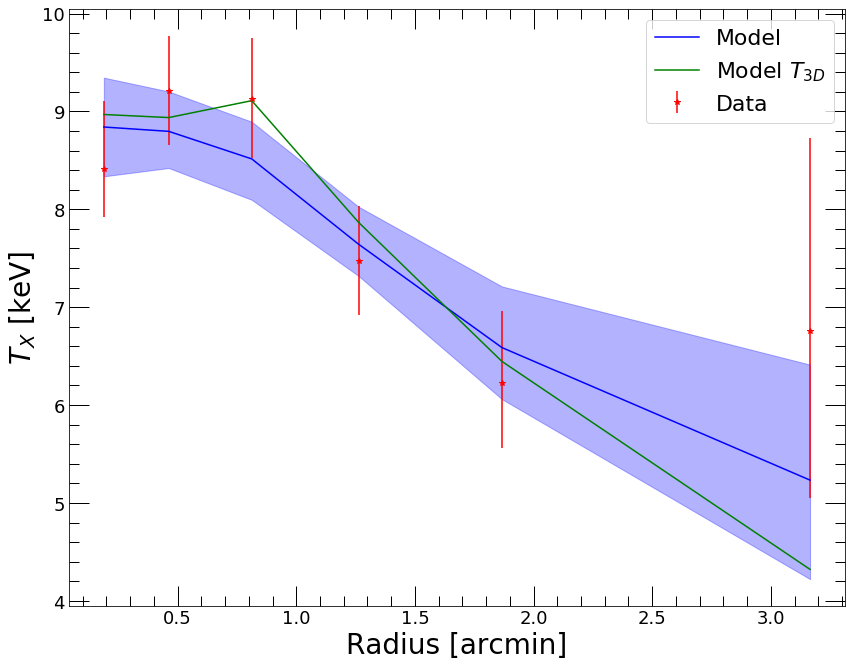

In [54]:
plt.clf()

fig = plt.figure(figsize=(13,10))
ax_size = [0.14, 0.14,
               0.83, 0.83]
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)

plt.xlabel('Radius [arcmin]', fontsize=28)
plt.ylabel('$T_{X}$ [keV]', fontsize=28)
plt.errorbar(spec_data.rref_x_am,spec_data.temp_x,yerr=np.array([spec_data.templ,spec_data.temph]),fmt='*',color='red', label='Data')
plt.plot(spec_data.rref_x_am,mforw.ktmod,color='blue', label='Model')
plt.fill_between(spec_data.rref_x_am, mforw.ktmod_lo, mforw.ktmod_hi, color='blue', alpha=0.3)
plt.plot(spec_data.rref_x_am,mforw.kt3d,color='green', label='Model $T_{3D}$')

plt.legend(fontsize=22)

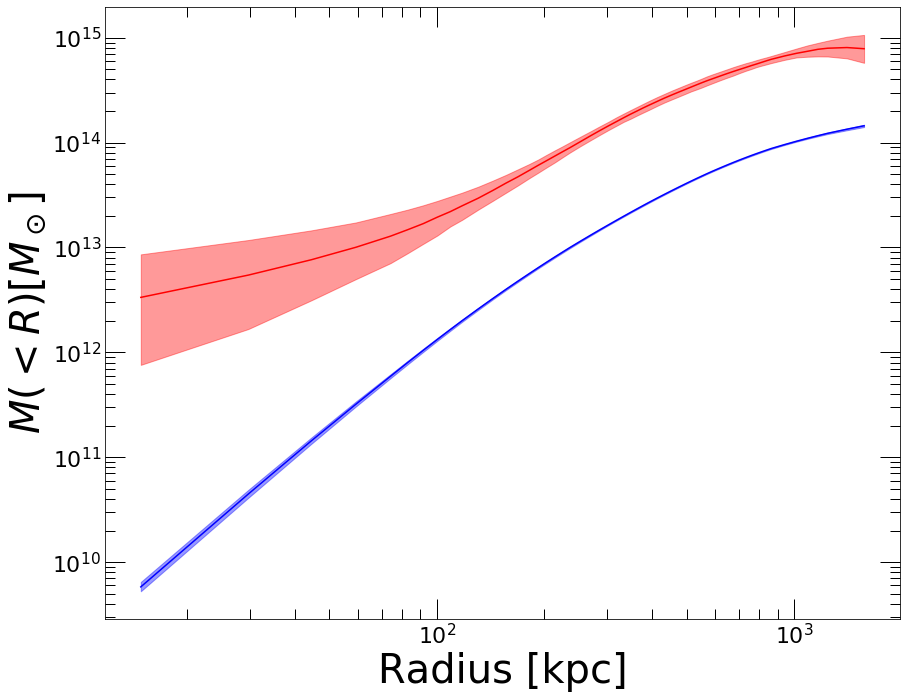

In [55]:
res_forw, fig = hydromass.mass_forw_from_samples(mforw, modforw, plot=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7d178e5fa0>,
      dtype=object)

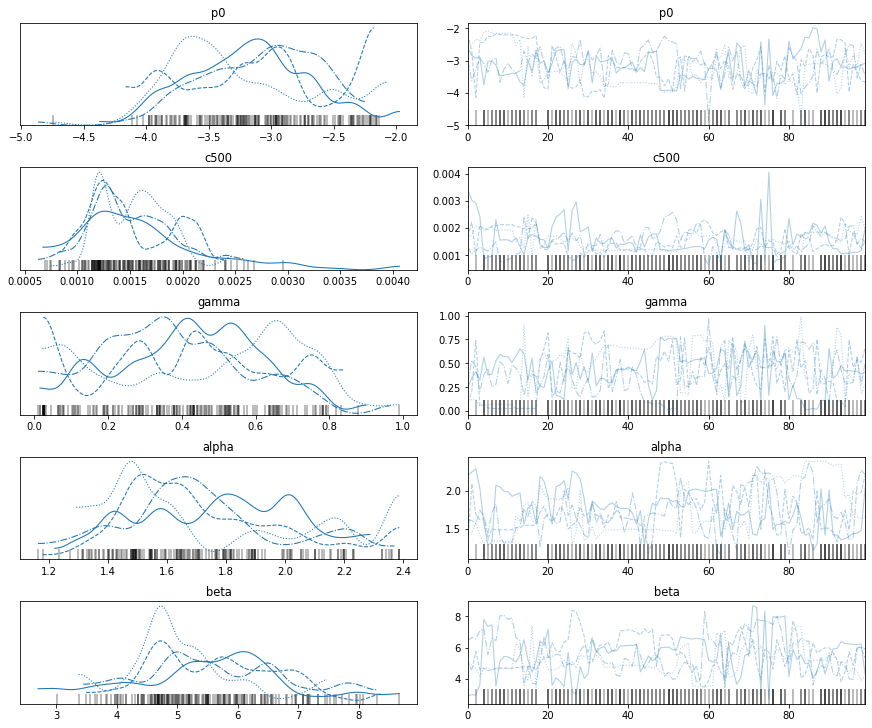

In [56]:
import pymc3 as pm

pm.traceplot(mforw.trace, var_names=['p0','c500','gamma','alpha','beta'])

<Figure size 432x288 with 0 Axes>

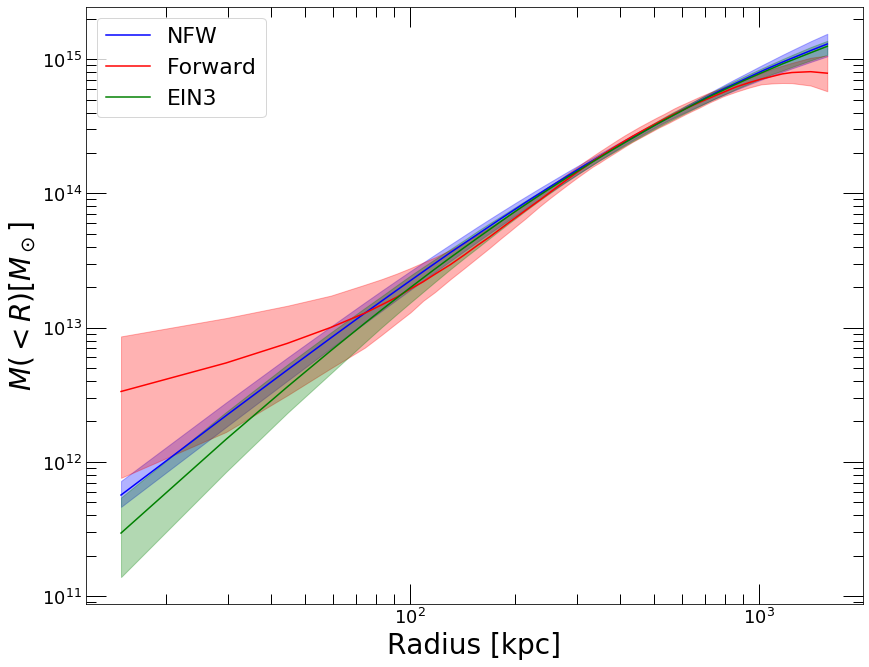

In [57]:
plt.clf()

fig = plt.figure(figsize=(13,10))
ax_size = [0.14, 0.14,
               0.83, 0.83]
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radius [kpc]', fontsize=28)
plt.ylabel('$M(<R) [M_\odot]$', fontsize=28)
plt.plot(res_mass['R_OUT'], res_mass['MASS'],color='blue', label='NFW')
plt.fill_between(res_mass['R_OUT'], res_mass['MASS_LO'], res_mass['MASS_HI'], color='blue', alpha=0.3)

plt.plot(res_forw['R_OUT'], res_forw['MASS'], color='red', label='Forward')
plt.fill_between(res_forw['R_OUT'], res_forw['MASS_LO'], res_forw['MASS_HI'], color='red', alpha=0.3)

plt.plot(res_ein['R_OUT'], res_ein['MASS'],color='green', label='EIN3')
plt.fill_between(res_ein['R_OUT'], res_ein['MASS_LO'], res_ein['MASS_HI'], color='green', alpha=0.3)

plt.legend(fontsize=22)
plt.savefig('comp_nfw_ein3_forw.pdf')

## Polytropic fit

In [58]:
mpoly = hydromass.Mhyd(sbprofile=p2, 
                        spec_data=spec_data, 
                        redshift=z_m0451, 
                        cosmo=pyproffit.cosmo)

modpoly = hydromass.Polytropic(model='GammaR')
#modforw = hydromass.Forward()

mpoly.emissivity(nh=nh_m0451, rmf=rsp, elow=0.7, ehigh=1.2)

No output directory name provided, will output to subdirectory "mhyd" 
Luminosity distance to the source: 3199.29 Mpc
At the redshift of the source 1 arcmin is 392.511 kpc
Mean cluster temperature: 8.161195  keV


In [59]:
mpoly.run_polytropic(polytropic=modpoly, nmcmc=100, tune=100)

coefs -187.90419872441586
p0_interval__ -0.7913620439338243
Gamma0_interval__ -1.1264022130874443
GammaR_interval__ -1.3342208492851697
Rs_interval__ -1.1157504232392135
Running MCMC...


logp = 19.949, ||grad|| = 0.0088879: 100%|██████████| 1825/1825 [00:00<00:00, 1860.64it/s]
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Rs, GammaR, Gamma0, p0, coefs]
Sampling 4 chains, 171 divergences: 100%|██████████| 800/800 [00:23<00:00, 33.86draws/s]
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5677995641540791, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance p

Done.
 Total computing time is:  0.5419105291366577  minutes


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8beb35b550>,
      dtype=object)

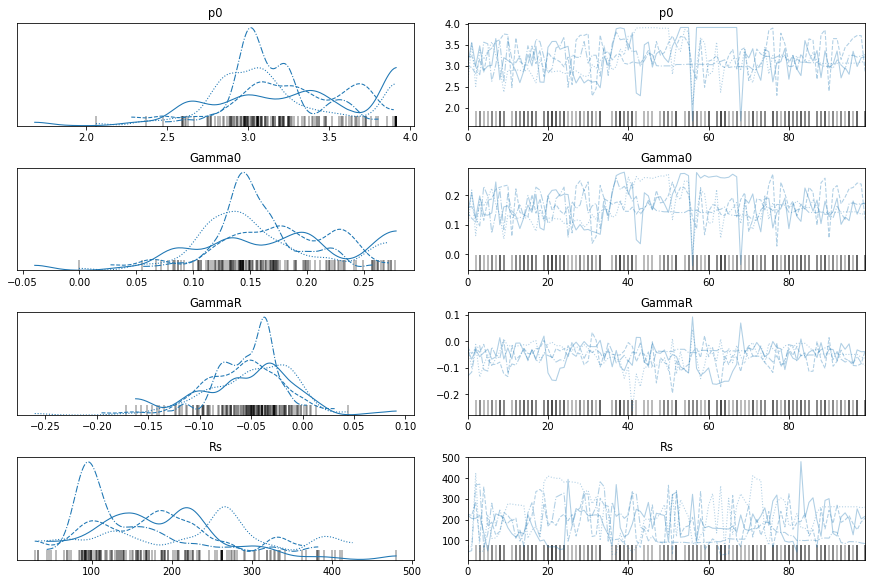

In [10]:
import pymc3 as pm

pm.traceplot(mpoly.trace, var_names=['p0', 'Gamma0', 'GammaR', 'Rs'])

<Figure size 432x288 with 0 Axes>

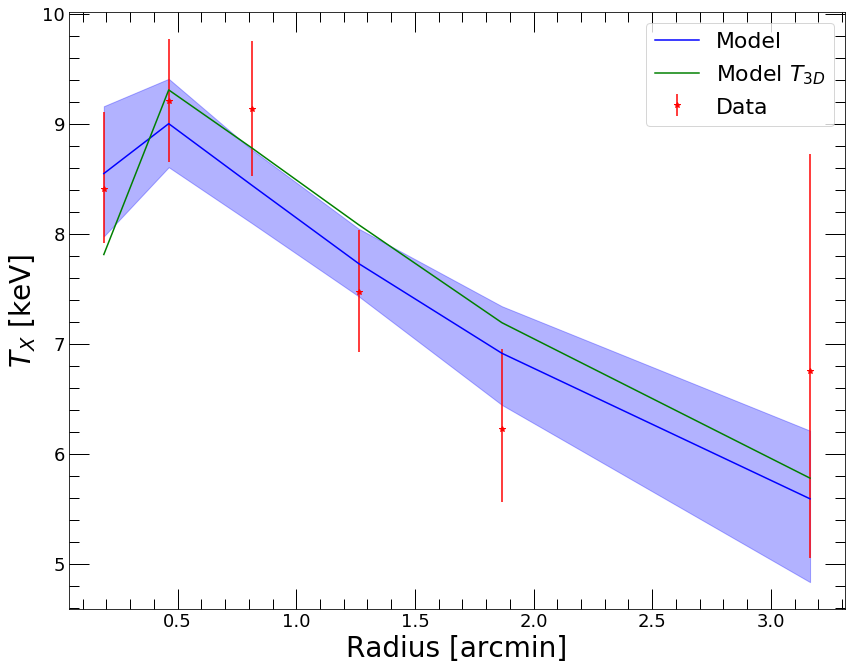

In [11]:
plt.clf()

fig = plt.figure(figsize=(13,10))
ax_size = [0.14, 0.14,
               0.83, 0.83]
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)

plt.xlabel('Radius [arcmin]', fontsize=28)
plt.ylabel('$T_{X}$ [keV]', fontsize=28)
plt.errorbar(mpoly.rref_x_am,mpoly.temp_x,yerr=np.array([mpoly.templ,mpoly.temph]),fmt='*',color='red', label='Data')
plt.plot(mpoly.rref_x_am,mpoly.ktmod,color='blue', label='Model')
plt.fill_between(mpoly.rref_x_am, mpoly.ktmod_lo, mpoly.ktmod_hi, color='blue', alpha=0.3)
plt.plot(mpoly.rref_x_am,mpoly.kt3d,color='green', label='Model $T_{3D}$')

plt.legend(fontsize=22)

In [11]:
mpolydens = hydromass.Mhyd(profile=p2, 
                        spec_data='../../cluster_data/VLP/MACS0451/spectral_results_MACS0451.fits', 
                        redshift=z_m0451, 
                        cosmo=pyproffit.cosmo)

modpolydens = hydromass.Polytropic(model='GammaN', redshift=z_m0451)
#modforw = hydromass.Forward()

mpolydens.emissivity(nh=nh_m0451, rmf=rsp, elow=0.7, ehigh=1.2)



No output directory name provided, will output to subdirectory "mhyd" 
Luminosity distance to the source: 3152.47 Mpc
At the redshift of the source 1 arcmin is 386.766 kpc
Reading spectral data from file ../../cluster_data/VLP/MACS0451/spectral_results_MACS0451.fits
Mean cluster temperature: 8.161195  keV


In [12]:
print(modpolydens.start)

mpolydens.run_polytropic(polytropic=modpolydens, nmcmc=100, tune=100)

[0.02, -5.731551259825176, 1.02003952, 0.99, -0.152564]
coefs -187.90419872441586
p0_interval__ -0.32508677234607175
dummylogn0 -0.9189385332046727
dummytrans -0.9189385332046727
dummyGamma0 -0.9189385332046727
dummyscale -0.9189385332046727
Running MCMC...


logp = 22.631, ||grad|| = 0.019821: 100%|██████████| 725/725 [00:00<00:00, 1922.16it/s]  
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dummyscale, dummyGamma0, dummytrans, dummylogn0, p0, coefs]
Sampling 4 chains, 173 divergences: 100%|██████████| 800/800 [00:27<00:00, 29.53draws/s]
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4993955681260098, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or repa

Done.
 Total computing time is:  0.5416202346483866  minutes


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7dc2ef0d30>,
      dtype=object)

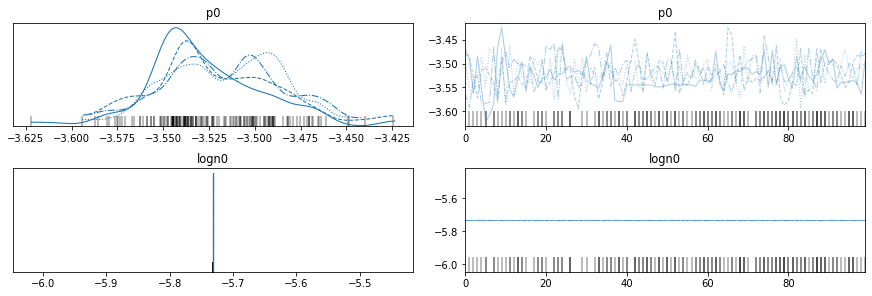

In [13]:
import pymc3 as pm

pm.traceplot(mpolydens.trace, var_names=['p0', 'logn0'])

<Figure size 432x288 with 0 Axes>

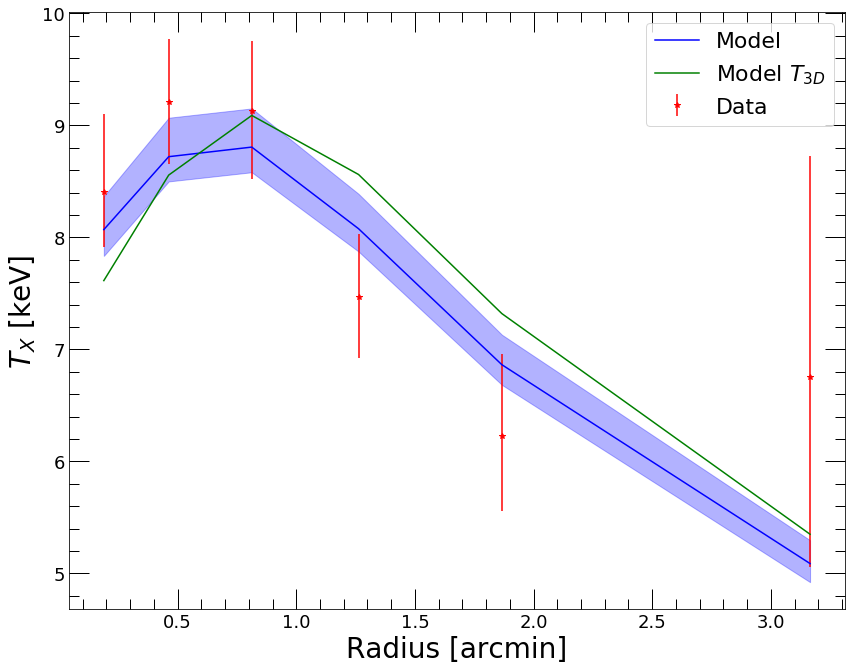

In [14]:
plt.clf()

fig = plt.figure(figsize=(13,10))
ax_size = [0.14, 0.14,
               0.83, 0.83]
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)

plt.xlabel('Radius [arcmin]', fontsize=28)
plt.ylabel('$T_{X}$ [keV]', fontsize=28)
plt.errorbar(mpolydens.rref_x_am,mpolydens.temp_x,yerr=np.array([mpolydens.templ,mpolydens.temph]),fmt='*',color='red', label='Data')
plt.plot(mpolydens.rref_x_am,mpolydens.ktmod,color='blue', label='Model')
plt.fill_between(mpolydens.rref_x_am, mpolydens.ktmod_lo, mpolydens.ktmod_hi, color='blue', alpha=0.3)
plt.plot(mpolydens.rref_x_am,mpolydens.kt3d,color='green', label='Model $T_{3D}$')

plt.legend(fontsize=22)
plt.savefig('tests/poly/kt_poly.pdf')

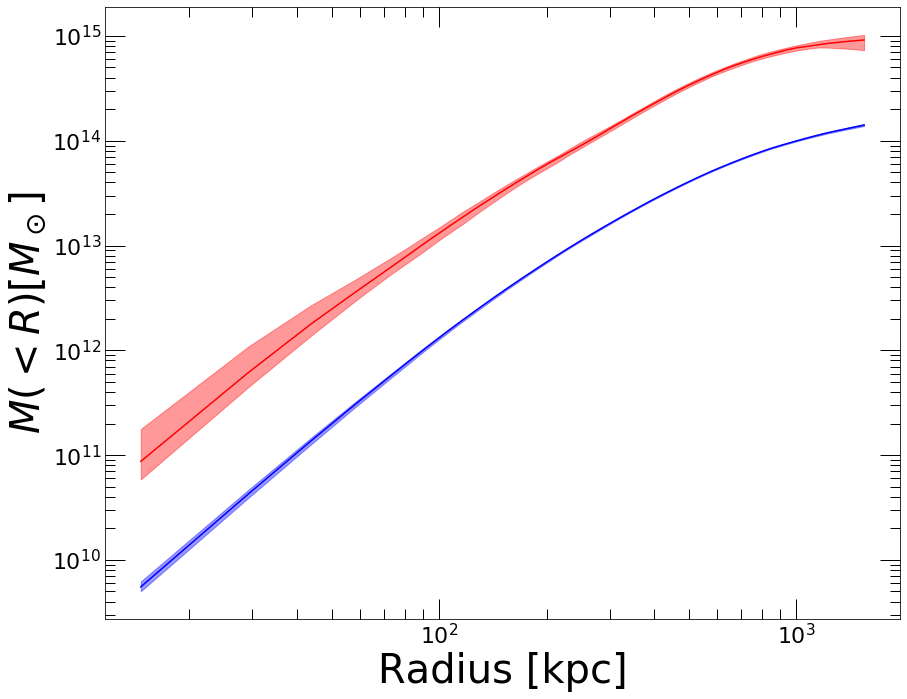

In [15]:
res_poly, fig = hydromass.mass_poly_from_samples(mpolydens, modpolydens, plot=True)

<Figure size 432x288 with 0 Axes>

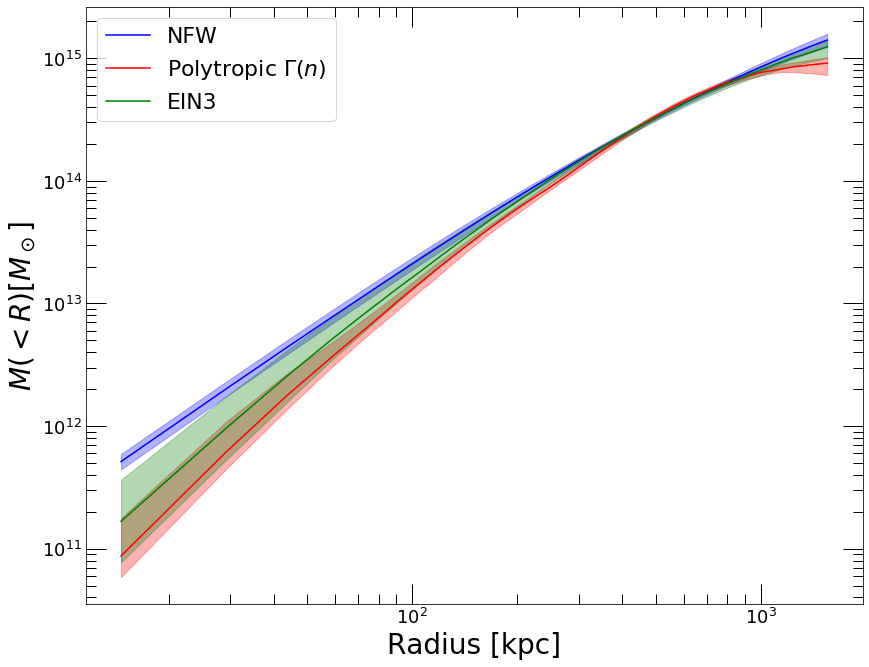

In [53]:
plt.clf()

fig = plt.figure(figsize=(13,10))
ax_size = [0.14, 0.14,
               0.83, 0.83]
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radius [kpc]', fontsize=28)
plt.ylabel('$M(<R) [M_\odot]$', fontsize=28)
plt.plot(res_mass['R_OUT'], res_mass['MASS'],color='blue', label='NFW')
plt.fill_between(res_mass['R_OUT'], res_mass['MASS_LO'], res_mass['MASS_HI'], color='blue', alpha=0.3)

plt.plot(res_poly['R_OUT'], res_poly['MASS'],color='red', label='Polytropic $\Gamma(n)$')
plt.fill_between(res_poly['R_OUT'], res_poly['MASS_LO'], res_poly['MASS_HI'], color='red', alpha=0.3)

plt.plot(res_ein['R_OUT'], res_ein['MASS'],color='green', label='EIN3')
plt.fill_between(res_ein['R_OUT'], res_ein['MASS_LO'], res_ein['MASS_HI'], color='green', alpha=0.3)

plt.legend(fontsize=22)
plt.savefig('tests/poly/poly_mass_comparison.pdf')


In [17]:
pfit = np.median(np.exp(mpolydens.trace['p0']))

In [18]:
eofz = pyproffit.cosmo.efunc(z_m0451)

M500 = 451. * np.power(pfit, 3./2.) * eofz ** (-4)

print(M500)

0.7363310409778694


In [19]:
err_pfit= np.std(np.exp(mpolydens.trace['p0']))

In [20]:
err_M500 = 451. * 3./2. * np.power(pfit, 1./2.) * eofz ** (-4) * err_pfit

print(err_M500)

0.036531611149656515


In [21]:
all_pfit = np.exp(mpolydens.trace['p0'])
all_m5 = 451. * np.power(all_pfit, 3./2.) * eofz ** (-4)
print(np.median(all_m5), np.std(all_m5))

0.7363310525099396 0.036680456519252995


## Non-thermal pressure correction

In the case of the NFW model we can try to correct for non-thermal pressure by using the model for the turbulent pressure support by Angelinelli+20. Here the parameters describing the non-thermal pressure support are assumed to be described by a multivariate normal. The generated non-thermal pressure profile is subtracted from the total model pressure to create a model for the thermal pressure only, which is then adjusted to the data. The final mass model will thus be marginalized over the non-thermal pressure uncertainty.

In [27]:
mnt = hydromass.Mhyd(sbprofile=p2, 
                       spec_data=spec_data,
                       redshift=z_m0451, 
                       cosmo=pyproffit.cosmo)

modnt = hydromass.Model(massmod='NFW')

mnt.emissivity(nh=nh_m0451, rmf=rsp, elow=0.7, ehigh=1.2)

No output directory name provided, will output to subdirectory "mhyd" 
Luminosity distance to the source: 3199.29 Mpc
At the redshift of the source 1 arcmin is 392.511 kpc
Mean cluster temperature: 8.161195  keV


In [28]:
mnt.run(model=modnt, nmcmc=100, tune=100, pnt=True)

coefs -187.90419872441586
cdelta_interval__ -1.7985669453191007
rdelta_interval__ -0.8404761994539018
logp0_interval__ -1.2303705795943691
Pnt 3.6838915639120837
Running MCMC...


logp = 21.756, ||grad|| = 0.029745: 100%|██████████| 907/907 [00:00<00:00, 1388.81it/s]  
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Pnt, logp0, rdelta, cdelta, coefs]
Sampling 4 chains, 161 divergences: 100%|██████████| 800/800 [00:37<00:00, 21.33draws/s]
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4675387253606966, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptanc

Done.
 Total computing time is:  0.7632068991661072  minutes


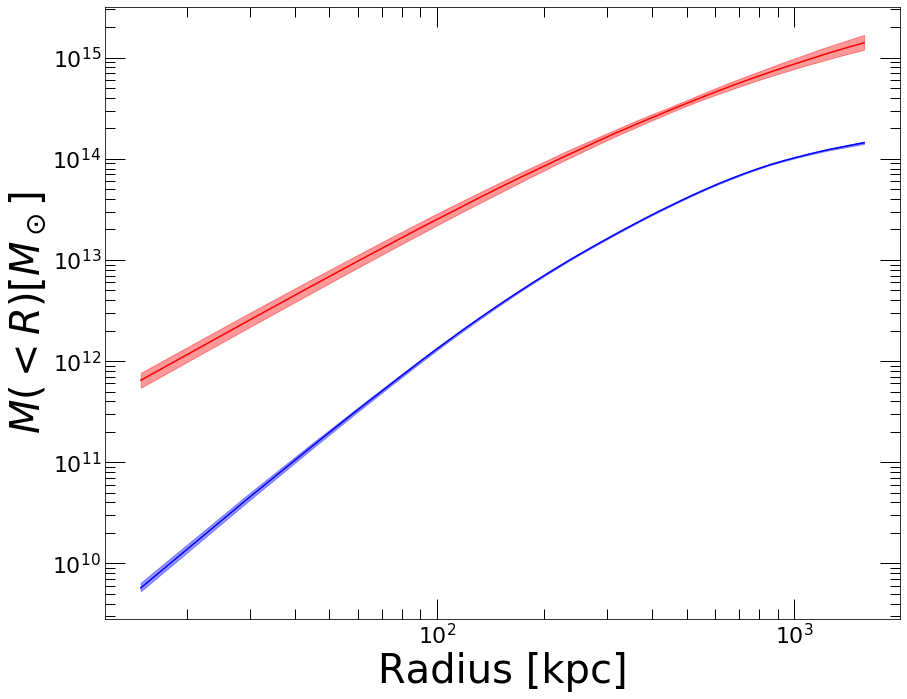

In [29]:
res_pnt, fig = hydromass.mass_from_samples(Mhyd=mnt, model=modnt, plot=True)


In [42]:
hydromass.write_all_mdelta(Mhyd=mnt, model=modnt, outfile='mhyd/NFW_Pnt.jou')

<Figure size 432x288 with 0 Axes>

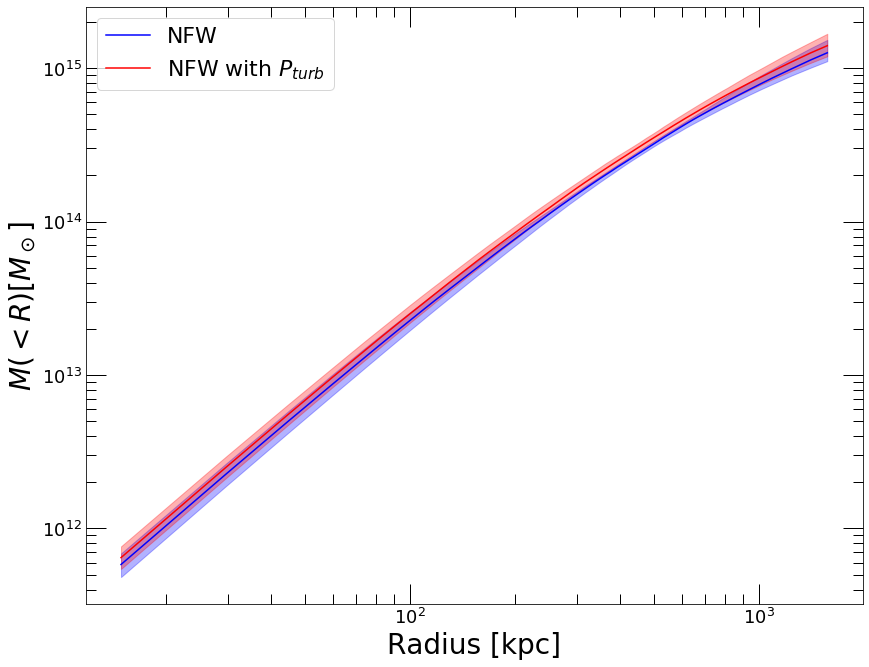

In [34]:
plt.clf()

fig = plt.figure(figsize=(13,10))
ax_size = [0.14, 0.14,
               0.83, 0.83]
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radius [kpc]', fontsize=28)
plt.ylabel('$M(<R) [M_\odot]$', fontsize=28)
plt.plot(res_mass['R_OUT'], res_mass['MASS'],color='blue', label='NFW')
plt.fill_between(res_mass['R_OUT'], res_mass['MASS_LO'], res_mass['MASS_HI'], color='blue', alpha=0.3)

plt.plot(res_pnt['R_OUT'], res_pnt['MASS'],color='red', label='NFW with $P_{turb}$')
plt.fill_between(res_pnt['R_OUT'], res_pnt['MASS_LO'], res_pnt['MASS_HI'], color='red', alpha=0.3)

plt.legend(fontsize=22)
plt.savefig('tests/pnt_mass_comparison.pdf')


In [35]:
profs_pnt = hydromass.prof_hires(Mhyd=mnt, model=modnt)

<Figure size 432x288 with 0 Axes>

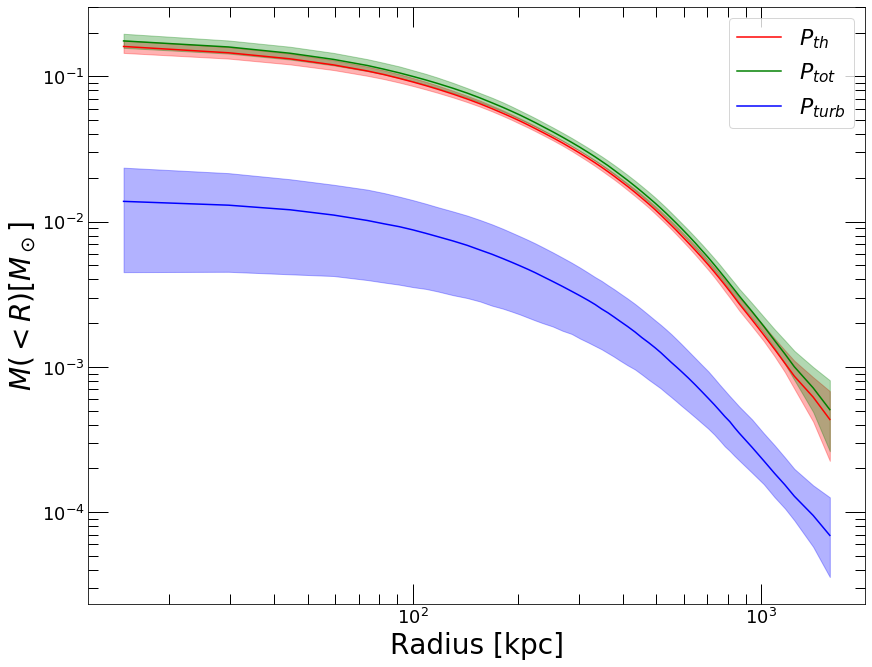

In [40]:
plt.clf()
fig = plt.figure(figsize=(13,10))
ax_size = [0.14, 0.14,
               0.83, 0.83]
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radius [kpc]', fontsize=28)
plt.ylabel('$M(<R) [M_\odot]$', fontsize=28)

plt.plot(profs_pnt['R_OUT'], profs_pnt['P_TH'],color='red', label='$P_{th}$')
plt.fill_between(profs_pnt['R_OUT'], profs_pnt['P_TH_LO'], profs_pnt['P_TH_HI'], color='red', alpha=0.3)

plt.plot(profs_pnt['R_OUT'], profs_pnt['P_TOT'],color='green', label='$P_{tot}$')
plt.fill_between(profs_pnt['R_OUT'], profs_pnt['P_TOT_LO'], profs_pnt['P_TOT_HI'], color='green', alpha=0.3)

plt.plot(profs_pnt['R_OUT'], profs_pnt['P_NT'],color='blue', label='$P_{turb}$')
plt.fill_between(profs_pnt['R_OUT'], profs_pnt['P_NT_LO'], profs_pnt['P_NT_HI'], color='blue', alpha=0.3)


plt.legend(fontsize=22)
plt.savefig('tests/pressure_profiles_pnt.pdf')


In [41]:
res_mass['MASS'] / res_pnt['MASS']

array([0.90192262, 0.90320941, 0.90281681, 0.90156421, 0.90218572,
       0.90240635, 0.90420183, 0.90520531, 0.90764833, 0.90740692,
       0.90458348, 0.90303851, 0.90233306, 0.90532555, 0.90762334,
       0.90887334, 0.91018744, 0.91130643, 0.91199276, 0.91115464,
       0.91370063, 0.91244007, 0.91139308, 0.9093073 , 0.90922599,
       0.91162125, 0.91207872, 0.91166999, 0.91094011, 0.91233019,
       0.91190233, 0.91112678, 0.91097859, 0.91048781, 0.91142117,
       0.91271597, 0.91605187, 0.91484809, 0.91423591, 0.91564533,
       0.91508327, 0.91592575, 0.91379498, 0.91236953, 0.91207271,
       0.91084717, 0.90945216, 0.90781894, 0.90736481, 0.90693114,
       0.90539903, 0.90557949, 0.9053415 , 0.902075  , 0.90065161,
       0.89947414, 0.89893879])

In [43]:
all_alpha = hydromass.alpha_turb_np(profs_pnt['R_OUT'], mnt.samppar, mnt.redshift, mnt.pnt_pars)

alpha, alpha_lo, alpha_hi = np.percentile(all_alpha, [50., 50.-68.3/2., 50.+68.3/2.], axis=1)

<Figure size 432x288 with 0 Axes>

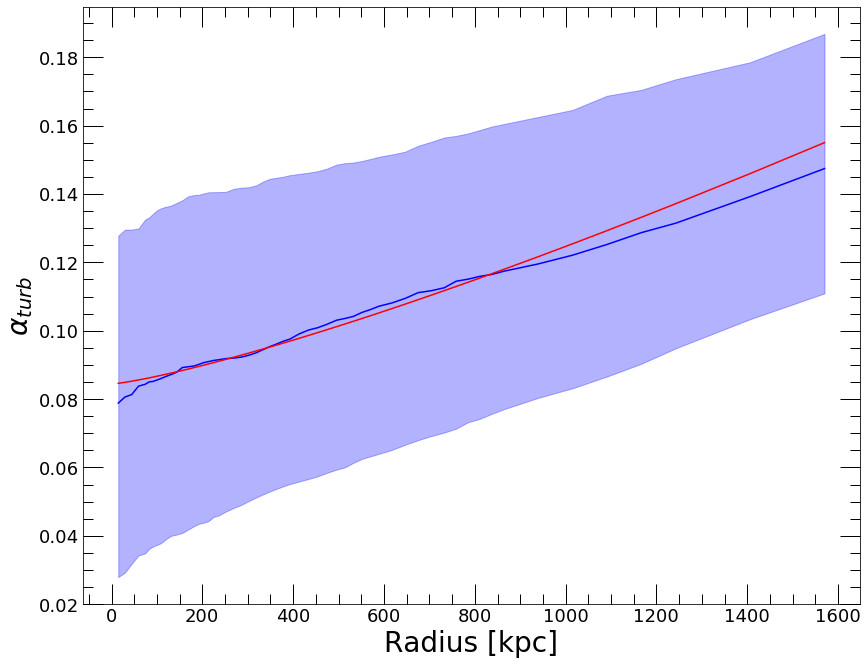

In [50]:
plt.clf()
fig = plt.figure(figsize=(13,10))
ax_size = [0.14, 0.14,
               0.83, 0.83]
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
plt.xlabel('Radius [kpc]', fontsize=28)
plt.ylabel('$\\alpha_{turb}$', fontsize=28)

plt.plot(profs_pnt['R_OUT'], alpha,color='blue', label='Posterior')
plt.fill_between(profs_pnt['R_OUT'], alpha_lo, alpha_hi, color='blue', alpha=0.3)

r2m = profs_pnt['R_OUT']/2124/1.3
alpha_ang = 0.1427 * r2m ** 1.246 + 0.0844
plt.plot(profs_pnt['R_OUT'], alpha_ang, color='red', label='Angelinelli+20')


## Non-parametric GP reconstruction

In [9]:
tmGP = hydromass.Mhyd(sbprofile=p2, 
                       spec_data=spec_data,
                       redshift=z_m0451, 
                       cosmo=pyproffit.cosmo)

tmGP.emissivity(nh=nh_m0451, rmf=rsp, elow=0.7, ehigh=1.2)

tmGP.run_GP()

No output directory name provided, will output to subdirectory "mhyd" 
Luminosity distance to the source: 3199.29 Mpc
At the redshift of the source 1 arcmin is 392.511 kpc
Mean cluster temperature: 8.161195  keV
[  58.87661743   60.86204996   62.91443509   65.03603059   67.22917035
   69.496267     71.8398145    74.26239092   76.76666126   79.3553804
   82.03139613   84.79765223   87.65719181   90.61316054   93.66881022
   96.82750226  100.09271147  103.46802979  106.95717033  110.56397138
  114.29240068  118.14655978  122.13068851  126.24916972  130.50653401
  134.9074648   139.45680343  144.15955448  149.02089132  154.04616177
  159.24089398  164.61080253  170.16179471  175.89997699  181.8316618
  187.9633744   194.30186011  200.85409173  207.62727718  214.62886743
  221.86656475  229.34833111  237.08239699  245.07727041  253.34174631
  261.8849162   270.71617817  279.84524725  289.28216605  299.03731587
  309.12142806  319.54559587  330.32128662  341.46035434  352.9750528
  364.8780

logp = -233.76, ||grad|| = 0.0083098: 100%|██████████| 864/864 [00:00<00:00, 1060.02it/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [GP, coefs]
Sampling 4 chains, 1,448 divergences: 100%|██████████| 6000/6000 [04:40<00:00, 21.43draws/s]
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 596 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6730711190991832, but should be close to 0.8. Try to increase the number of tuning steps.
There were 335 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 457 divergences after tuning. Increase `target

Done.
 Total computing time is:  5.114488164583842  minutes


<Figure size 432x288 with 0 Axes>

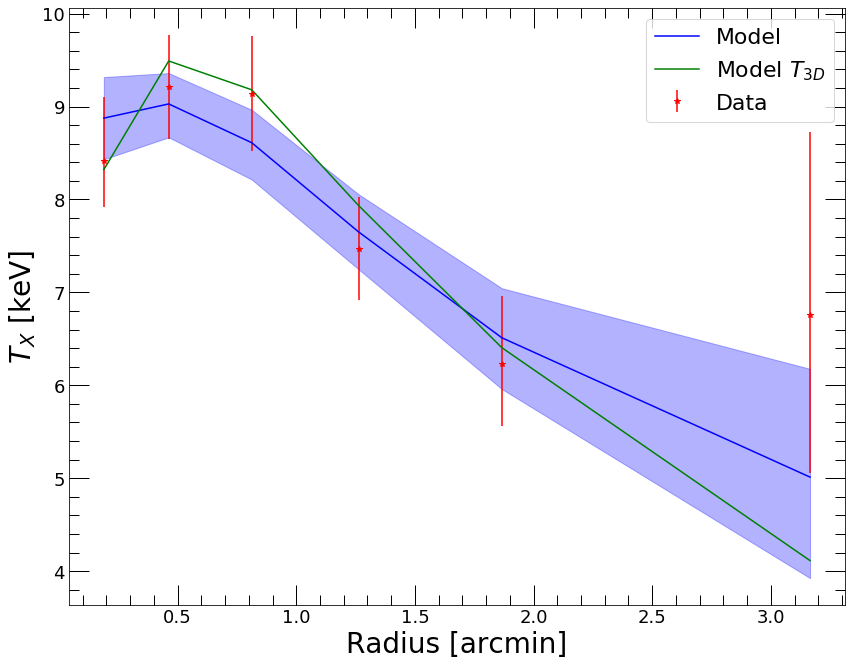

In [10]:
plt.clf()

fig = plt.figure(figsize=(13,10))
ax_size = [0.14, 0.14,
               0.83, 0.83]
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)

plt.xlabel('Radius [arcmin]', fontsize=28)
plt.ylabel('$T_{X}$ [keV]', fontsize=28)
plt.errorbar(spec_data.rref_x_am,spec_data.temp_x,yerr=np.array([spec_data.templ,spec_data.temph]),fmt='*',color='red', label='Data')
plt.plot(spec_data.rref_x_am,tmGP.ktmod,color='blue', label='Model')
plt.fill_between(spec_data.rref_x_am, tmGP.ktmod_lo, tmGP.ktmod_hi, color='blue', alpha=0.3)
plt.plot(spec_data.rref_x_am,tmGP.kt3d,color='green', label='Model $T_{3D}$')

plt.legend(fontsize=22)


In [11]:
res_GP = hydromass.mass_GP_from_samples(tmGP)

<Figure size 432x288 with 0 Axes>

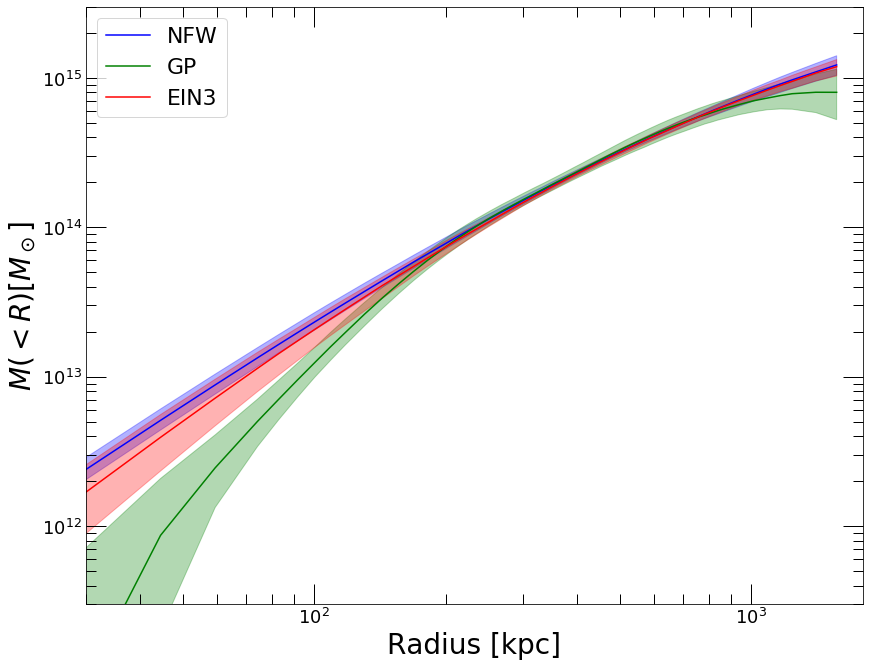

In [24]:
plt.clf()

fig = plt.figure(figsize=(13,10))
ax_size = [0.14, 0.14,
               0.83, 0.83]
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radius [kpc]', fontsize=28)
plt.ylabel('$M(<R) [M_\odot]$', fontsize=28)
plt.plot(res_mass['R_OUT'], res_mass['MASS'],color='blue', label='NFW')
plt.fill_between(res_mass['R_OUT'], res_mass['MASS_LO'], res_mass['MASS_HI'], color='blue', alpha=0.3)

plt.plot(res_GP['R_OUT'], res_GP['MASS'], color='green', label='GP')
plt.fill_between(res_GP['R_OUT'], res_GP['MASS_LO'], res_GP['MASS_HI'], color='green', alpha=0.3)

plt.plot(res_ein['R_OUT'], res_ein['MASS'],color='red', label='EIN3')
plt.fill_between(res_ein['R_OUT'], res_ein['MASS_LO'], res_ein['MASS_HI'], color='red', alpha=0.3)

plt.axis([30., 1800., 3e11, 3e15])

plt.legend(fontsize=22)


In [13]:
tmGP_2 = hydromass.Mhyd(sbprofile=p2, 
                       spec_data=spec_data,
                       redshift=z_m0451, 
                       cosmo=pyproffit.cosmo)

tmGP_2.emissivity(nh=nh_m0451, rmf=rsp, elow=0.7, ehigh=1.2)

tmGP_2.run_GP(bin_fact=2.)

No output directory name provided, will output to subdirectory "mhyd" 
Luminosity distance to the source: 3199.29 Mpc
At the redshift of the source 1 arcmin is 392.511 kpc
Mean cluster temperature: 8.161195  keV
[  58.87661743   60.86204996   62.91443509   65.03603059   67.22917035
   69.496267     71.8398145    74.26239092   76.76666126   79.3553804
   82.03139613   84.79765223   87.65719181   90.61316054   93.66881022
   96.82750226  100.09271147  103.46802979  106.95717033  110.56397138
  114.29240068  118.14655978  122.13068851  126.24916972  130.50653401
  134.9074648   139.45680343  144.15955448  149.02089132  154.04616177
  159.24089398  164.61080253  170.16179471  175.89997699  181.8316618
  187.9633744   194.30186011  200.85409173  207.62727718  214.62886743
  221.86656475  229.34833111  237.08239699  245.07727041  253.34174631
  261.8849162   270.71617817  279.84524725  289.28216605  299.03731587
  309.12142806  319.54559587  330.32128662  341.46035434  352.9750528
  364.8780

logp = -229.29, ||grad|| = 0.0332: 100%|██████████| 1162/1162 [00:01<00:00, 932.58it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [GP, coefs]
Sampling 4 chains, 1,756 divergences: 100%|██████████| 6000/6000 [05:22<00:00, 18.60draws/s]
There were 688 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4866221575029447, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 797 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4373658396806146, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or repara

Done.
 Total computing time is:  5.509648990631104  minutes


In [25]:
tmGP_05 = hydromass.Mhyd(sbprofile=p2, 
                       spec_data=spec_data,
                       redshift=z_m0451, 
                       cosmo=pyproffit.cosmo)

tmGP_05.emissivity(nh=nh_m0451, rmf=rsp, elow=0.7, ehigh=1.2)

tmGP_05.run_GP(bin_fact=0.5)

No output directory name provided, will output to subdirectory "mhyd" 
Luminosity distance to the source: 3199.29 Mpc
At the redshift of the source 1 arcmin is 392.511 kpc
Mean cluster temperature: 8.161195  keV
[  58.87661743   60.86204996   62.91443509   65.03603059   67.22917035
   69.496267     71.8398145    74.26239092   76.76666126   79.3553804
   82.03139613   84.79765223   87.65719181   90.61316054   93.66881022
   96.82750226  100.09271147  103.46802979  106.95717033  110.56397138
  114.29240068  118.14655978  122.13068851  126.24916972  130.50653401
  134.9074648   139.45680343  144.15955448  149.02089132  154.04616177
  159.24089398  164.61080253  170.16179471  175.89997699  181.8316618
  187.9633744   194.30186011  200.85409173  207.62727718  214.62886743
  221.86656475  229.34833111  237.08239699  245.07727041  253.34174631
  261.8849162   270.71617817  279.84524725  289.28216605  299.03731587
  309.12142806  319.54559587  330.32128662  341.46035434  352.9750528
  364.8780

logp = -229.99, ||grad|| = 0.052548: 100%|██████████| 1040/1040 [00:00<00:00, 1134.71it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [GP, coefs]
Sampling 4 chains, 1,604 divergences: 100%|██████████| 6000/6000 [05:44<00:00, 17.40draws/s]
There were 422 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6629547262400802, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 390 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7165331789009229, but should be close to 0.8. Try to increase the number of tuning steps.
There were 300 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4

Done.
 Total computing time is:  5.857152442137401  minutes


In [26]:
res_GP_2 = hydromass.mass_GP_from_samples(tmGP_2)

res_GP_05 = hydromass.mass_GP_from_samples(tmGP_05)


<Figure size 432x288 with 0 Axes>

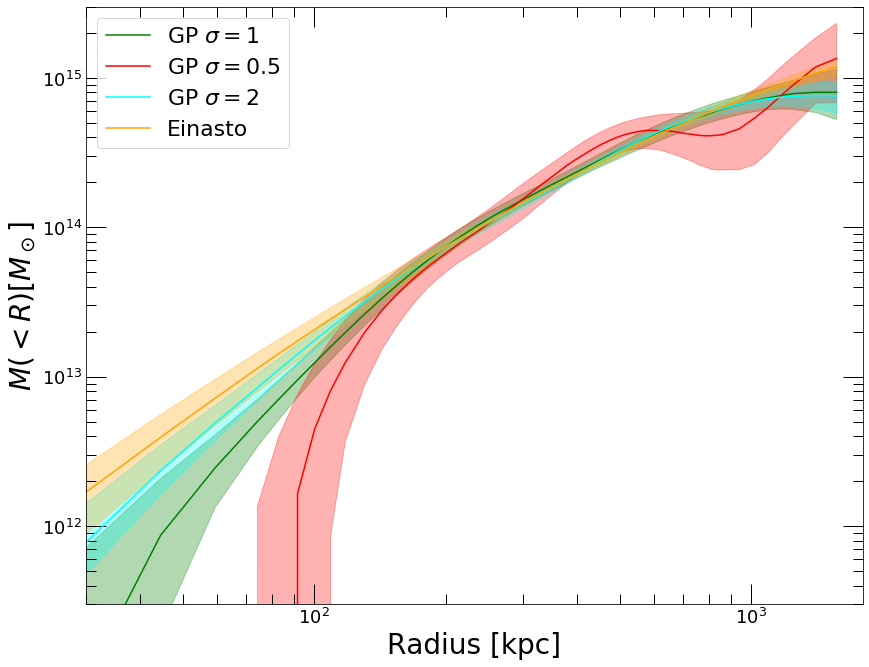

In [27]:
plt.clf()

fig = plt.figure(figsize=(13,10))
ax_size = [0.14, 0.14,
               0.83, 0.83]
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radius [kpc]', fontsize=28)
plt.ylabel('$M(<R) [M_\odot]$', fontsize=28)
# plt.plot(res_mass['R_OUT'], res_mass['MASS'],color='blue', label='NFW')
# plt.fill_between(res_mass['R_OUT'], res_mass['MASS_LO'], res_mass['MASS_HI'], color='blue', alpha=0.3)

plt.plot(res_GP['R_OUT'], res_GP['MASS'], color='green', label='GP $\sigma=1$')
plt.fill_between(res_GP['R_OUT'], res_GP['MASS_LO'], res_GP['MASS_HI'], color='green', alpha=0.3)

plt.plot(res_GP_05['R_OUT'], res_GP_05['MASS'], color='red', label='GP $\sigma=0.5$')
plt.fill_between(res_GP_05['R_OUT'], res_GP_05['MASS_LO'], res_GP_05['MASS_HI'], color='red', alpha=0.3)

plt.plot(res_GP_2['R_OUT'], res_GP_2['MASS'], color='cyan', label='GP $\sigma=2$')
plt.fill_between(res_GP_2['R_OUT'], res_GP_2['MASS_LO'], res_GP_2['MASS_HI'], color='cyan', alpha=0.3)

plt.plot(res_ein['R_OUT'], res_ein['MASS'],color='orange', label='Einasto')
plt.fill_between(res_ein['R_OUT'], res_ein['MASS_LO'], res_ein['MASS_HI'], color='orange', alpha=0.3)

plt.axis([30., 1800., 3e11, 3e15])

plt.legend(fontsize=22)


<Figure size 432x288 with 0 Axes>

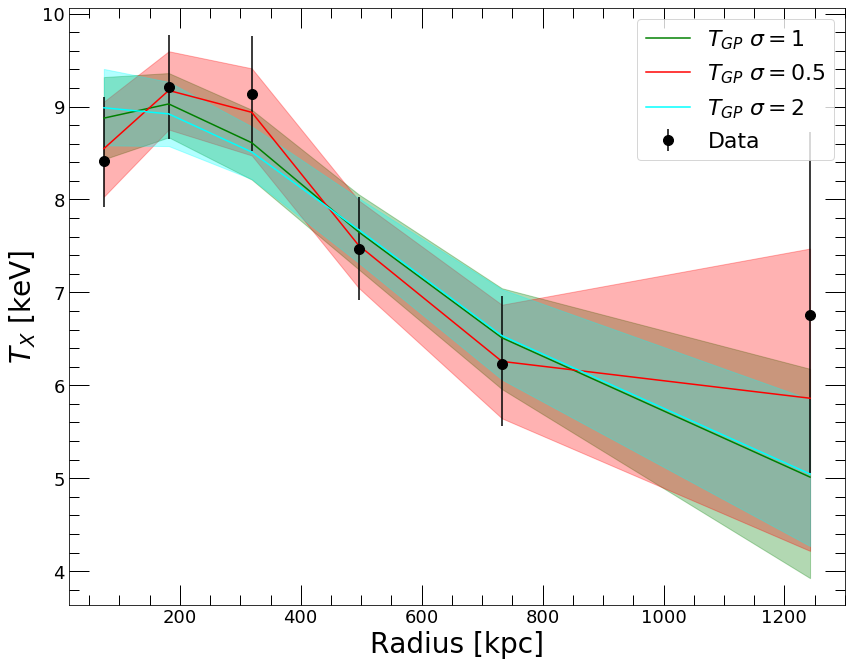

In [28]:
plt.clf()

fig = plt.figure(figsize=(13,10))
ax_size = [0.14, 0.14,
               0.83, 0.83]
ax = fig.add_axes(ax_size)
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right=True, top=True)
ax.tick_params(length=10, width=1, which='minor', direction='in', right=True, top=True)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)

plt.xlabel('Radius [kpc]', fontsize=28)
plt.ylabel('$T_{X}$ [keV]', fontsize=28)
plt.errorbar(spec_data.rref_x,spec_data.temp_x,yerr=np.array([spec_data.templ,spec_data.temph]),fmt='o',color='black', markersize=10, label='Data')
plt.plot(spec_data.rref_x,tmGP.ktmod,color='green', label='$T_{GP}$ $\sigma=1$')
plt.fill_between(spec_data.rref_x, tmGP.ktmod_lo, tmGP.ktmod_hi, color='green', alpha=0.3)
# plt.plot(spec_data.rref_x_am,tmGP.kt3d,color='green', label='Model $T_{3D}$')

plt.plot(spec_data.rref_x,tmGP_05.ktmod,color='red', label='$T_{GP}$ $\sigma=0.5$')
plt.fill_between(spec_data.rref_x, tmGP_05.ktmod_lo, tmGP_05.ktmod_hi, color='red', alpha=0.3)

plt.plot(spec_data.rref_x,tmGP_2.ktmod,color='cyan', label='$T_{GP}$ $\sigma=2$')
plt.fill_between(spec_data.rref_x, tmGP_2.ktmod_lo, tmGP_2.ktmod_hi, color='cyan', alpha=0.3)

plt.legend(fontsize=22)


In [30]:
hydromass.cosmo.Om(z_m0451)

0.6170894941656737